In [2]:
# basic stuff 
from scipy import stats, signal, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.colab import files
import os
import sklearn
import time
import json
import math
import statsmodels.api as sm

# !pip install mat73

# dim reduction and visualization
from sklearn.decomposition import PCA
# !pip install umap
# !pip install umap-learn
# import umap.umap_ as umap
from sklearn.manifold import TSNE

# torch stuff
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/xds_python/')

In [5]:
from xds import lab_data
import joint_angles

# Notebook Description - Data Preprocessing and Network Architecture

All neural data are in .mat files ("xds" files compatible with the package imported below) stored on my google drive. Jarvis kinematic data are stored on my local computer in csv's - it is necessary to upload every time you start a new runtime.

### Preprocessing - Jarvis Kinematics Data

Kinematics data were obtained from the prediction software Jarvis, which takes in videos as input and outputs 3D keypoint predictions, along with their likelihoods, in a csv. There are 23 keypoints on the monkey's hand, including fingertips, joints, palm, and wrist. Videos were captured at a rate of 30Hz (1 frame/33.3ms). Likelihoods were removed, producing a csv of shape num_frames x 69 (23 keypoints in 3D -> 69 columns). For the time being, csv's with any NaN values are ignored, but those with a small number of NaN's will likely be interpolated within the bounds of the Nyquist criterion.

### Preprocessing - Neural Data

The main field of interest in the xds files is "spike_counts". This field is an array containing spike information for each of the sorted units - 1's and 0's where threshold crossings do and do not occur. This data was preprocessed in the following way:
- Sorting was done before creating xds files. This was done manually using the OfflineSorter software to identify "units" - these can more or less be thought of as individual neurons. Electrodes often pick up signals from multiple neurons simultaneously, and distinguishing these neurons from one another might be helpful for our encoding project (note - this is not usually done for decoding, where neural signals are inputs, and kinematics are outputs). 
- xds files are now created, containing the spike_counts field. As mentioned, this is an array containing 1's and 0's every 1ms. These spikes are binned to 33ms (1's and 0's are summed in 33ms intervals), and then divided by 33ms to produce firing rates. Each element of the array is now the average number of spikes per ms across a 33ms interval. 33ms was chosen in accordance with the frame rate of the cameras used for the videos; this bin size reduces the number of neural data points to exactly the number of kinematic data points.
- Firing rates are now smoothed with a Gaussian filter. This is a standard practice in neuroscience - it produces a moving weighted average (where the weights are determined by a Gaussian distribution) and mitigates the effects of imperfections in the data collection process.



### Data batches and Network Architecture

- Data batching
  - Each session was broken into chunks of length 100. Therefore, a session with 18000 frames produces a dataset with 180 instances, each with length 100.
- Network Architecture
  - Temporal convolutional network with varying number of convolutional layers, ReLU, and single linear readout layer.

In [6]:
keypoint_list_names = ['Pinky_T_x','Pinky_T_y','Pinky_T_z',
                       'Pinky_D_x','Pinky_D_y','Pinky_D_z',
                       'Pinky_M_x','Pinky_M_y','Pinky_M_z',
                       'Pinky_P_x','Pinky_P_y','Pinky_P_z',
                       'Ring_T_x','Ring_T_y','Ring_T_z',
                       'Ring_D_x','Ring_D_y','Ring_D_z',
                       'Ring_M_x','Ring_M_y','Ring_M_z',
                       'Ring_P_x','Ring_P_y','Ring_P_z',
                       'Middle_T_x','Middle_T_y','Middle_T_z',
                       'Middle_D_x','Middle_D_y','Middle_D_z',
                       'Middle_M_x','Middle_M_y','Middle_M_z',
                       'Middle_P_x','Middle_P_y','Middle_P_z',
                       'Index_T_x','Index_T_y','Index_T_z',
                       'Index_D_x','Index_D_y','Index_D_z',
                       'Index_M_x','Index_M_y','Index_M_z',
                       'Index_P_x','Index_P_y','Index_P_z',
                       'Thumb_T_x','Thumb_T_y','Thumb_T_z',
                       'Thumb_D_x','Thumb_D_y','Thumb_D_z',
                       'Thumb_M_x','Thumb_M_y','Thumb_M_z',
                       'Thumb_P_x','Thumb_P_y','Thumb_P_z',
                       'Palm_x','Palm_y','Palm_z',
                       'Wrist_U_x','Wrist_U_y','Wrist_U_z',
                       'Wrist_R_x','Wrist_R_y','Wrist_R_z']
joint_names_list = ['Pinky DIP','Pinky PIP','Pinky MCP',
                    'Ring DIP','Ring PIP','Ring MCP',
                    'Middle DIP','Middle PIP','Middle MCP',
                    'Index DIP','Index PIP','Index MCP',
                    'Thumb DIP','Thumb PIP','Thumb MCP']

In [8]:
jarvispreds20210712 = np.genfromtxt('20210712_data3D.csv', delimiter = ',')
jarvispreds20210814 = np.genfromtxt('20210814_data3D.csv', delimiter = ',')
jarvispreds20211105 = np.genfromtxt('20211105_data3D.csv', delimiter = ',')
jarvispreds20220203 = np.genfromtxt('20220203_data3D.csv', delimiter = ',')
jarvispreds20220210_001 = np.genfromtxt('20220210uc_data3D.csv', delimiter = ',')
jarvispreds20220210_002 = np.genfromtxt('20220210pipe_data3D.csv', delimiter = ',')
jarvispreds20220224 = np.genfromtxt('20220224_data3D.csv', delimiter = ',')
jarvispreds20220405_002 = np.genfromtxt('20220405uc_data3D.csv', delimiter = ',')

In [9]:
jarvispreds_list_untrimmed = [jarvispreds20210712,jarvispreds20210814,jarvispreds20211105,jarvispreds20220203 
                    ,jarvispreds20220210_001,jarvispreds20220210_002,jarvispreds20220224,jarvispreds20220405_002]

In [10]:
# Remove likelihoods from jarvis csv's - they are every 4th column
# Trim videos to remove extra frames
jarvispreds_list = []
for jarvispred_untrimmed in jarvispreds_list_untrimmed:
  x = np.arange(92)
  liks = (np.arange(0, x.size+1, 4) -1)[1:]
  x = np.delete(x, liks)
  shape_before = jarvispred_untrimmed.shape
  num_frames = jarvispred_untrimmed.shape[0]
  num_frames_trimmed = int(num_frames/18000)*18000
  jarvispred_trimmed = jarvispred_untrimmed[:num_frames_trimmed, x]
  shape_after = jarvispred_trimmed.shape
  jarvispreds_list.append(jarvispred_trimmed)
  print('Shape before: {}, shape after: {}'.format(shape_before, shape_after))

Shape before: (37455, 92), shape after: (36000, 69)
Shape before: (55374, 92), shape after: (54000, 69)
Shape before: (36930, 92), shape after: (36000, 69)
Shape before: (18000, 92), shape after: (18000, 69)
Shape before: (18475, 92), shape after: (18000, 69)
Shape before: (18000, 92), shape after: (18000, 69)
Shape before: (18464, 92), shape after: (18000, 69)
Shape before: (18000, 92), shape after: (18000, 69)


In [11]:
binnedsortedspikes20210712 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/neuraldata/','20210712_Pop_FR_01.mat')
binnedsortedspikes20210814 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/neuraldata/','20210814_Pop_FR_001.mat')
binnedsortedspikes20211105 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/neuraldata/','20211105_Pop_FR_001.mat')
binnedsortedspikes20220203 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/neuraldata/','20220203_Pop_FR_003.mat')
binnedsortedspikes20220210_001 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/neuraldata/','20220210_Pop_FR_001.mat')
binnedsortedspikes20220210_002 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/neuraldata/','20220210_Pop_FR_002.mat')
binnedsortedspikes20220224 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/neuraldata/','20220224_Pop_FR_001.mat')
binnedsortedspikes20220405_002 = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/neuraldata/','20220405_Pop_FR_002.mat')

In [12]:
date_list = ['20210712','20210814','20211105', '20220203','20220210_001','20220210_002',
              '20220224','20220405']

In [13]:
neuraldata_list = [binnedsortedspikes20210712,binnedsortedspikes20210814,binnedsortedspikes20211105, 
                  binnedsortedspikes20220203,binnedsortedspikes20220210_001,binnedsortedspikes20220210_002,
                  binnedsortedspikes20220224,binnedsortedspikes20220405_002]

In [14]:
for binnedsortedspikes  in neuraldata_list:
    print(binnedsortedspikes.get_meta())

{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 1200.0040000000001, 'collect_date': '2021/7/12 20:17:2.453', 'raw_file_name': '20210712_Pop_FR_01', 'array': 'M1', 'processed_time': '05-Dec-2022'}
{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 1800.0095, 'collect_date': '2021/8/14 18:45:31.170', 'raw_file_name': 'Pop_20210814_FR_001', 'array': 'M1', 'processed_time': '05-Dec-2022'}
{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 1200.0040000000001, 'collect_date': '2021/11/5 21:5:8.218', 'raw_file_name': '20211105_Pop_FR_001', 'array': 'M1', 'processed_time': '08-Dec-2022'}
{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 600.0095, 'collect_date': '2022/2/3 21:43:57.717', 'raw_file_name': '20220203_Pop_FR_003', 'array': 'M1', 'processed_time': '05-Dec-2022'}
{'monkey_name': 'Pop', 'hand': 'Left', 'task_name': 'FR', 'duration': 600.0095, 'collect_date': '2022/2/10 22:16:49.778', 'raw_file_name': '2022

In [15]:
# Check for nans in neural data
for i, (binnedsortedspikes, jarvispred) in enumerate(zip(neuraldata_list, jarvispreds_list)):
    date = date_list[i]
    num_neural_nans = np.sum(np.isnan(binnedsortedspikes.spike_counts))
    print('DATE: {} \nNeural num nans: {}\n'\
          .format(date, num_neural_nans))

DATE: 20210712 
Neural num nans: 0

DATE: 20210814 
Neural num nans: 0

DATE: 20211105 
Neural num nans: 0

DATE: 20220203 
Neural num nans: 0

DATE: 20220210_001 
Neural num nans: 0

DATE: 20220210_002 
Neural num nans: 0

DATE: 20220224 
Neural num nans: 0

DATE: 20220405 
Neural num nans: 0



In [16]:
# Check for nans in jarvis csv's and keep only those with non-nan values
jarvispreds_list_nonans = []
neuraldata_list_nonans = []
date_list_nonans = []
for i, (binnedsortedspikes, jarvispred) in enumerate(zip(neuraldata_list, jarvispreds_list)):
    date = date_list[i]
    num_jarv_nans = np.sum(np.isnan(jarvispred))
    print('DATE: {} \nNeural File Time Duration: {} \nNeural File Spikes Length: {} \nJarvis Preds Length: {} \nJarvis Preds num nans: {}\n'\
          .format(date, binnedsortedspikes.get_meta()['duration'], binnedsortedspikes.spike_counts.shape, jarvispred.shape[0], num_jarv_nans))
    if num_jarv_nans == 0:
        print('KEPT - NO NANS: {}\n'.format(date))
        jarvispreds_list_nonans.append(jarvispred)
        neuraldata_list_nonans.append(binnedsortedspikes)
        date_list_nonans.append(date)

DATE: 20210712 
Neural File Time Duration: 1200.0040000000001 
Neural File Spikes Length: (1200005, 142) 
Jarvis Preds Length: 36000 
Jarvis Preds num nans: 690

DATE: 20210814 
Neural File Time Duration: 1800.0095 
Neural File Spikes Length: (1800010, 145) 
Jarvis Preds Length: 54000 
Jarvis Preds num nans: 81696

DATE: 20211105 
Neural File Time Duration: 1200.0040000000001 
Neural File Spikes Length: (1200005, 113) 
Jarvis Preds Length: 36000 
Jarvis Preds num nans: 276

DATE: 20220203 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (600010, 44) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

KEPT - NO NANS: 20220203

DATE: 20220210_001 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (600010, 62) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

KEPT - NO NANS: 20220210_001

DATE: 20220210_002 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (600010, 62) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

KEPT - NO NAN

In [17]:
# bin spike counts, convert to firing rates, and smooth with gaussian filter (stand. dev. = 2xbin_size)
bin_size = 1/30
for binnedsortedspikes in neuraldata_list_nonans:
    print('Shape before binning+smoothing is: {}'.format(binnedsortedspikes.spike_counts.shape))
    binnedsortedspikes.update_bin_data(bin_size)                                      #bin
    binnedsortedspikes.spike_counts = binnedsortedspikes.spike_counts/bin_size        #convert to firing rates
    binnedsortedspikes.smooth_binned_spikes(bin_size, 'gaussian', bin_size*2)         #smooth
    print('Shape after binning+smoothing is: {}'.format(binnedsortedspikes.spike_counts.shape))

Shape before binning+smoothing is: (600010, 44)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (18001, 44)
Shape before binning+smoothing is: (600010, 62)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (18001, 62)
Shape before binning+smoothing is: (600010, 62)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (18001, 62)
Shape before binning+smoothing is: (600010, 108)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (18001, 108)


# Data Visualization

In [16]:
for i in range(len(neuraldata_list_nonans)):
    date = neuraldata_list_nonans[i].get_meta()['collect_date']
    print(date)

2022/2/3 21:43:57.717
2022/2/10 22:16:49.778
2022/2/10 22:29:3.268
2022/2/24 21:2:12.116


In [35]:
def visualize_neuraloutputs_histogram(dataset, nrows, ncols, figsize):
    print('Below 100 Hz is generally indicative of good data quality.')
    date = dataset.get_meta()['collect_date']
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols)
    fig.set_size_inches(30, 50)
    # fig.suptitle('Session Dataset {}'.format(dataset.session_num))
    fig.tight_layout(pad=3.0)
    fig.subplots_adjust(top=0.95)
    for i in range(nrows*ncols):
        j = math.floor(i/ncols)
        k = i%ncols
        if (date != '2022/2/24 21:2:12.116') and (i ==(nrows*ncols -1)):
            ax[j][k].hist(np.zeros(dim_vals.shape[0]), bins = 300)
        else:
            dim_vals = dataset.spike_counts[:,i]
            ax[j][k].hist(dim_vals, bins = 300)
        # dim_vals = dataset[:,i]
        # ax[j][k].hist(dim_vals, bins = 300)
        ax[j][k].set_title('Electrode {}'.format(i))
        ax[j][k].set_xlabel('Firing Rate (Hz)')
        ax[j][k].set_ylabel('Count')
      
    plt.show()

In [36]:
for neuraldata in neuraldata_list_nonans:
    print(neuraldata.spike_counts.shape)

(18001, 44)
(18001, 62)
(18001, 62)
(18001, 108)


<IPython.core.display.Javascript object>

Below 100 Hz is generally indicative of good data quality.


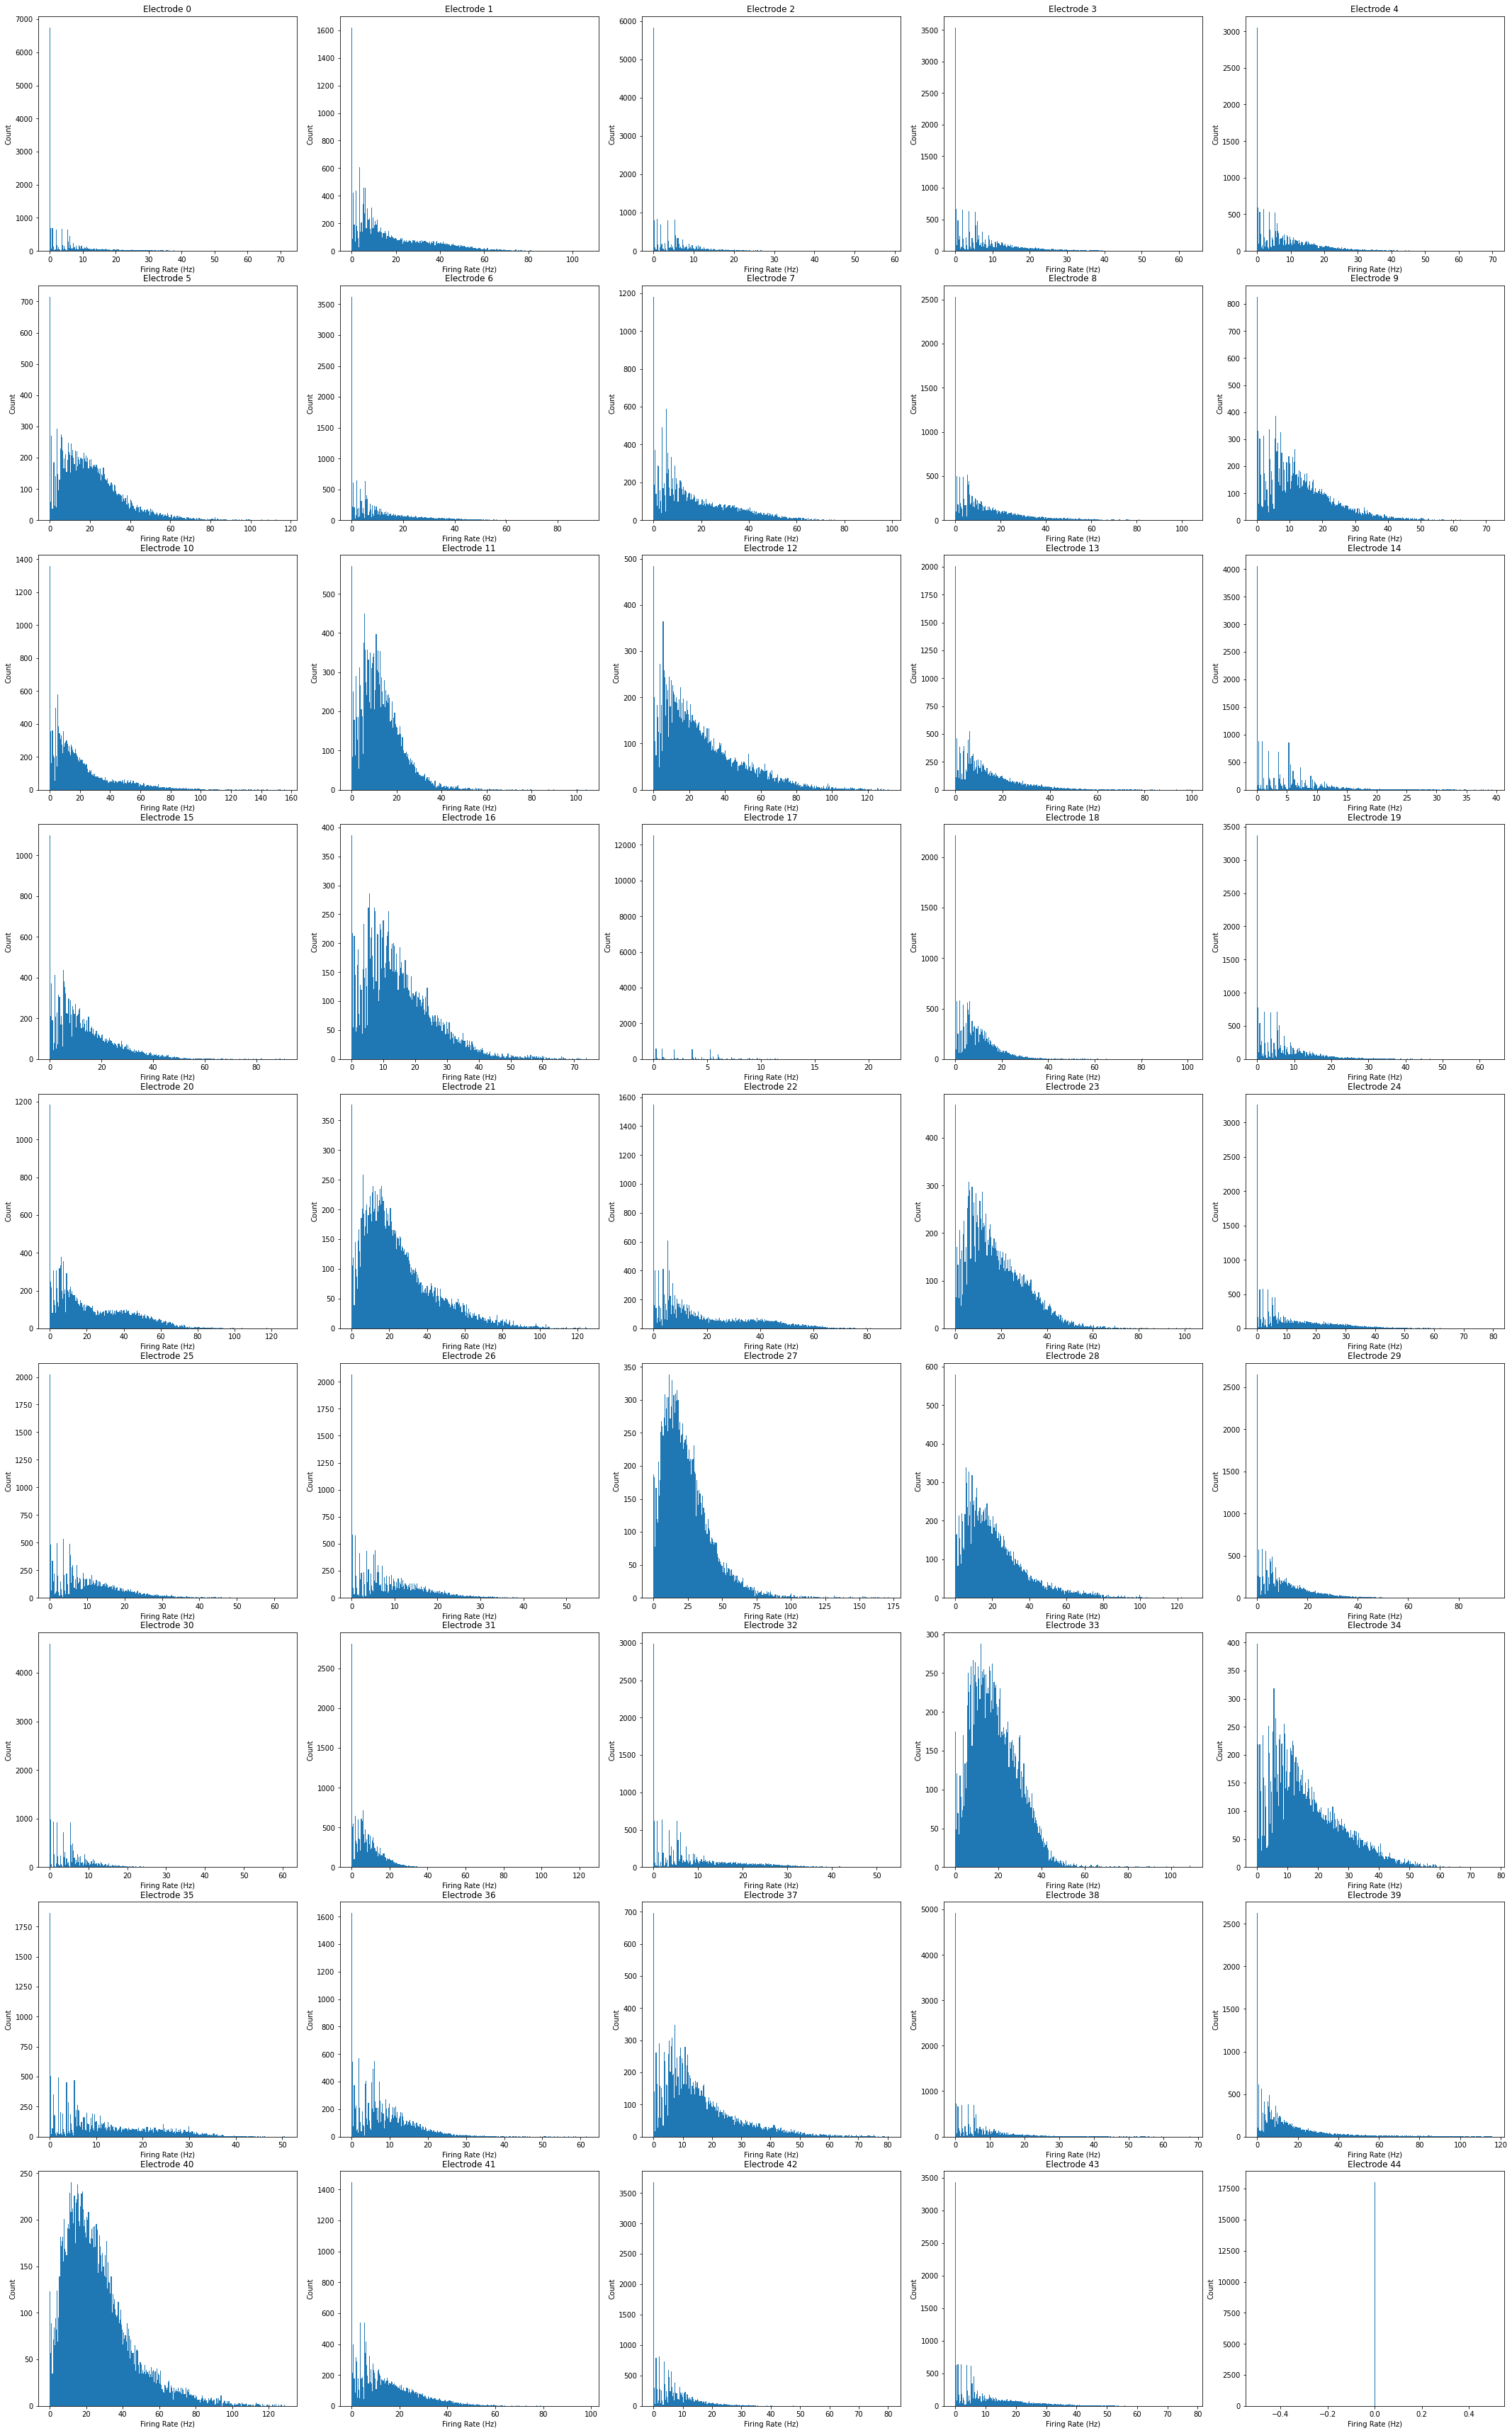

Below 100 Hz is generally indicative of good data quality.


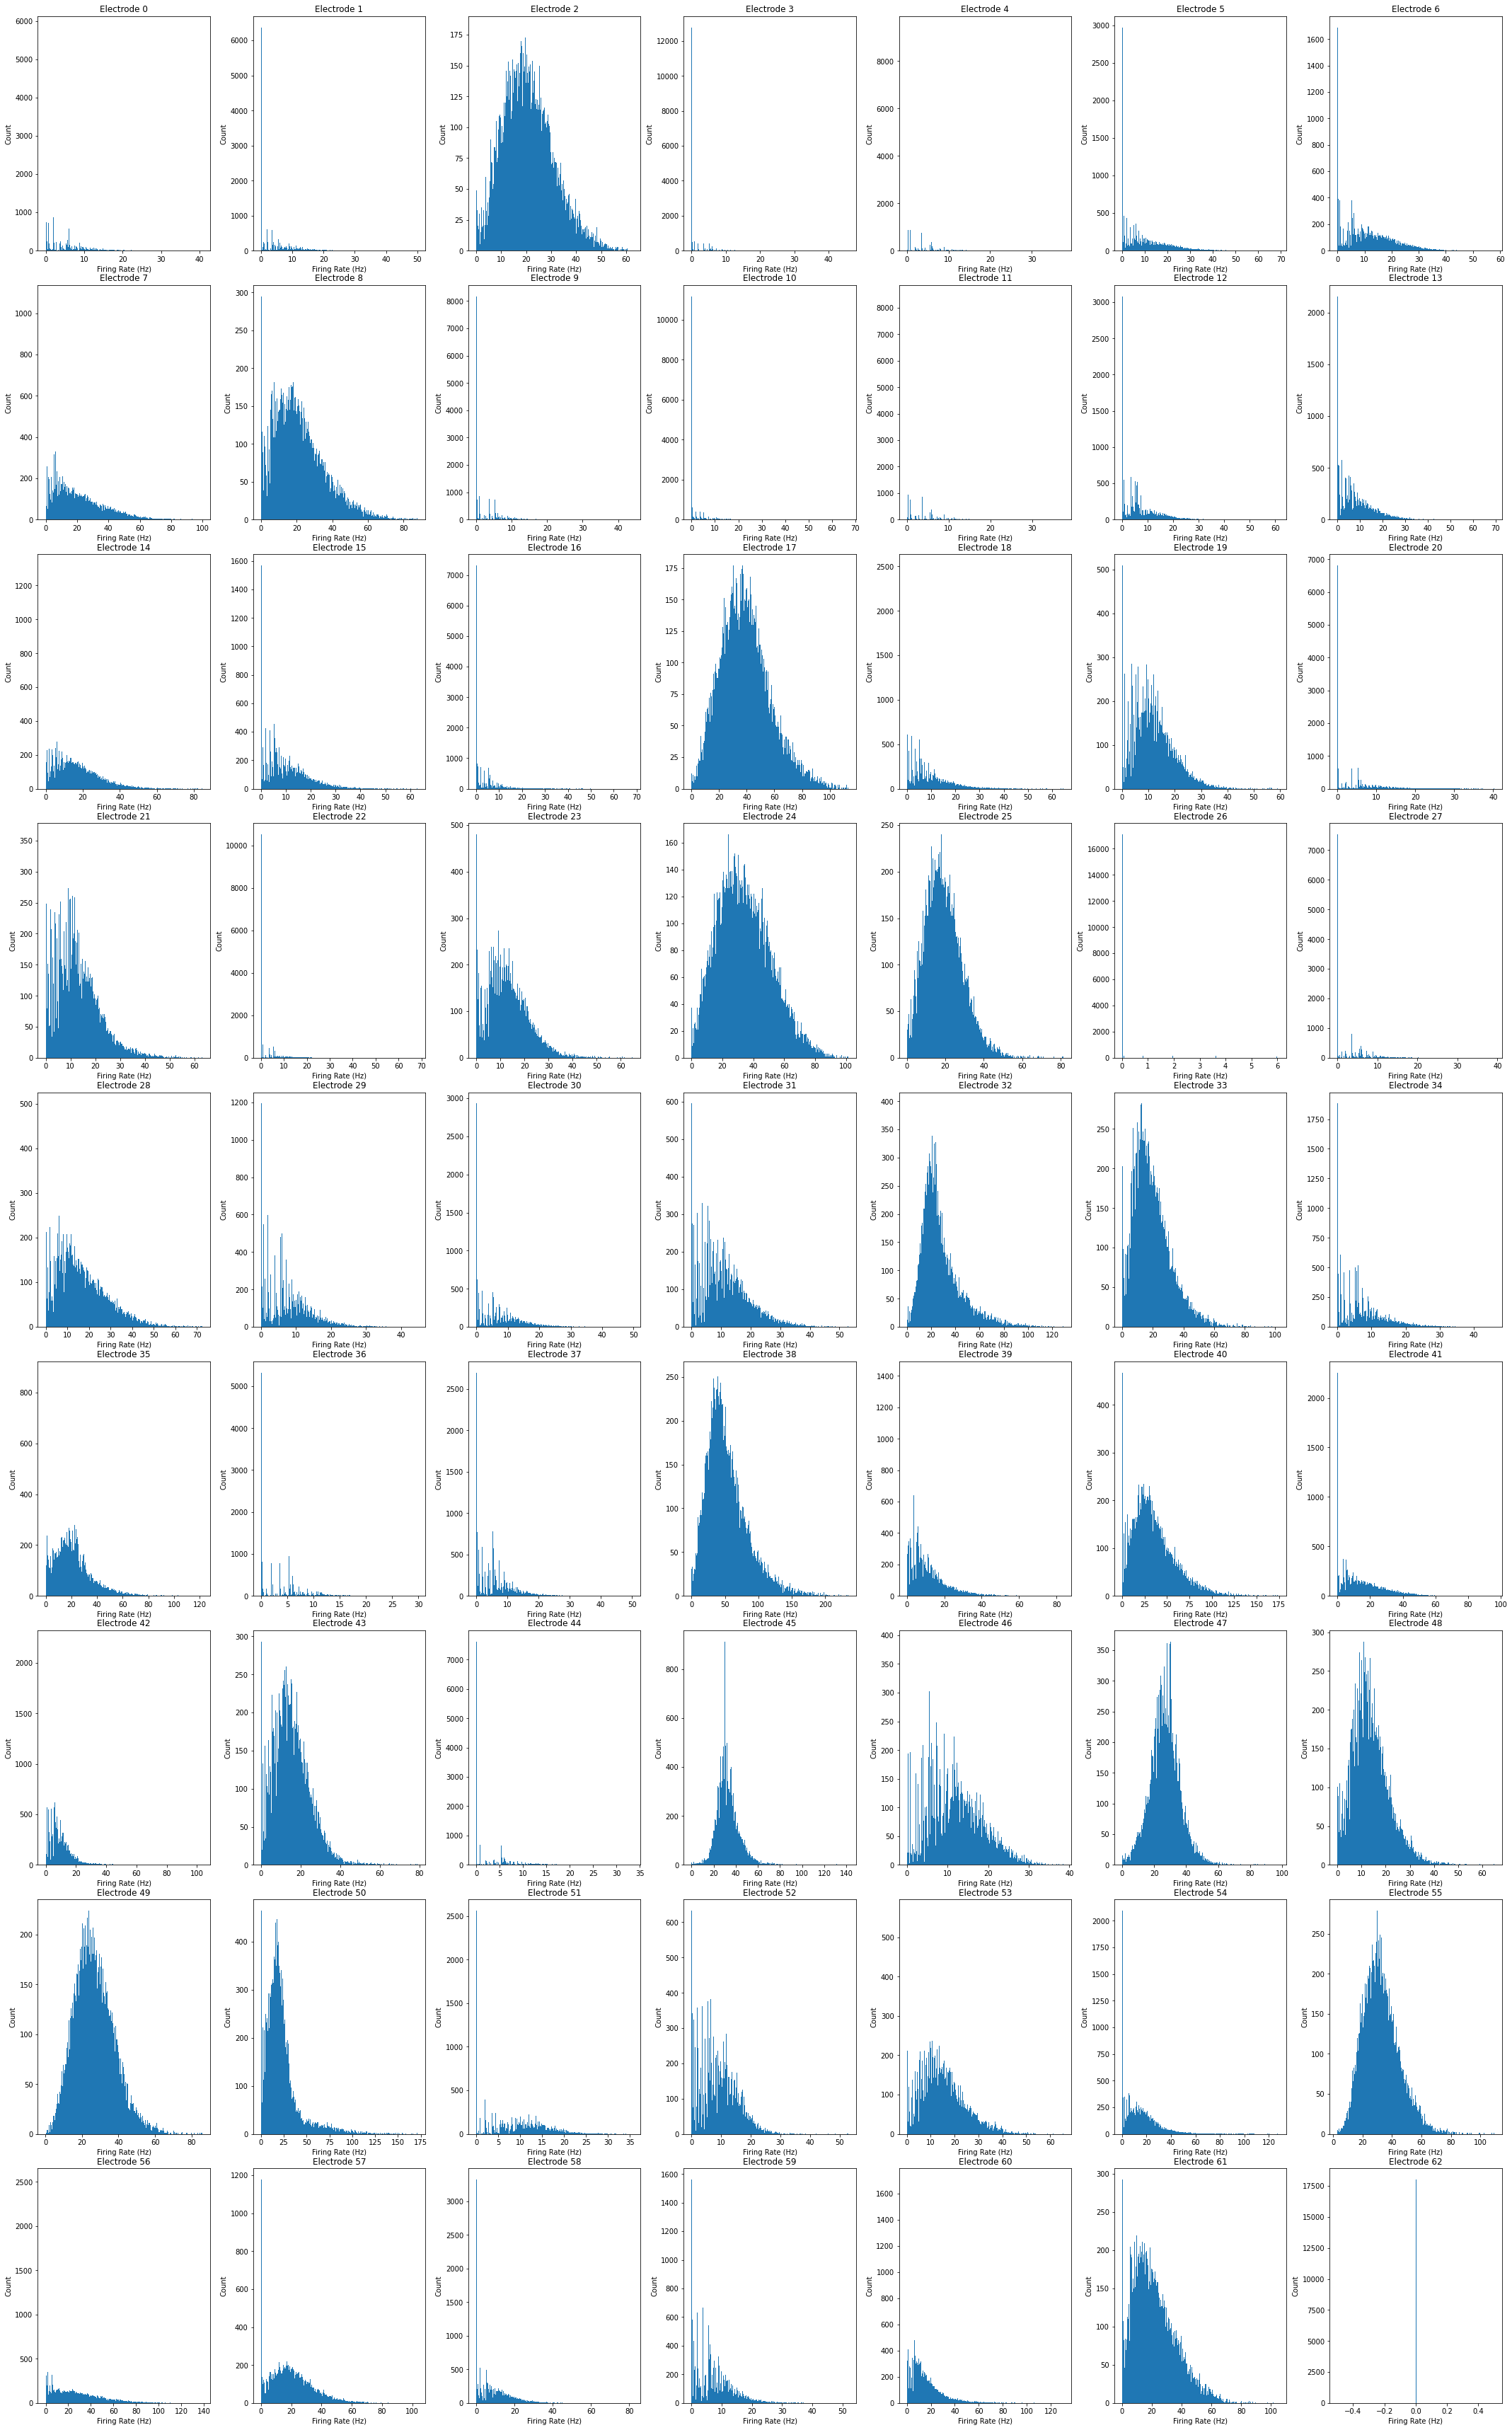

Below 100 Hz is generally indicative of good data quality.


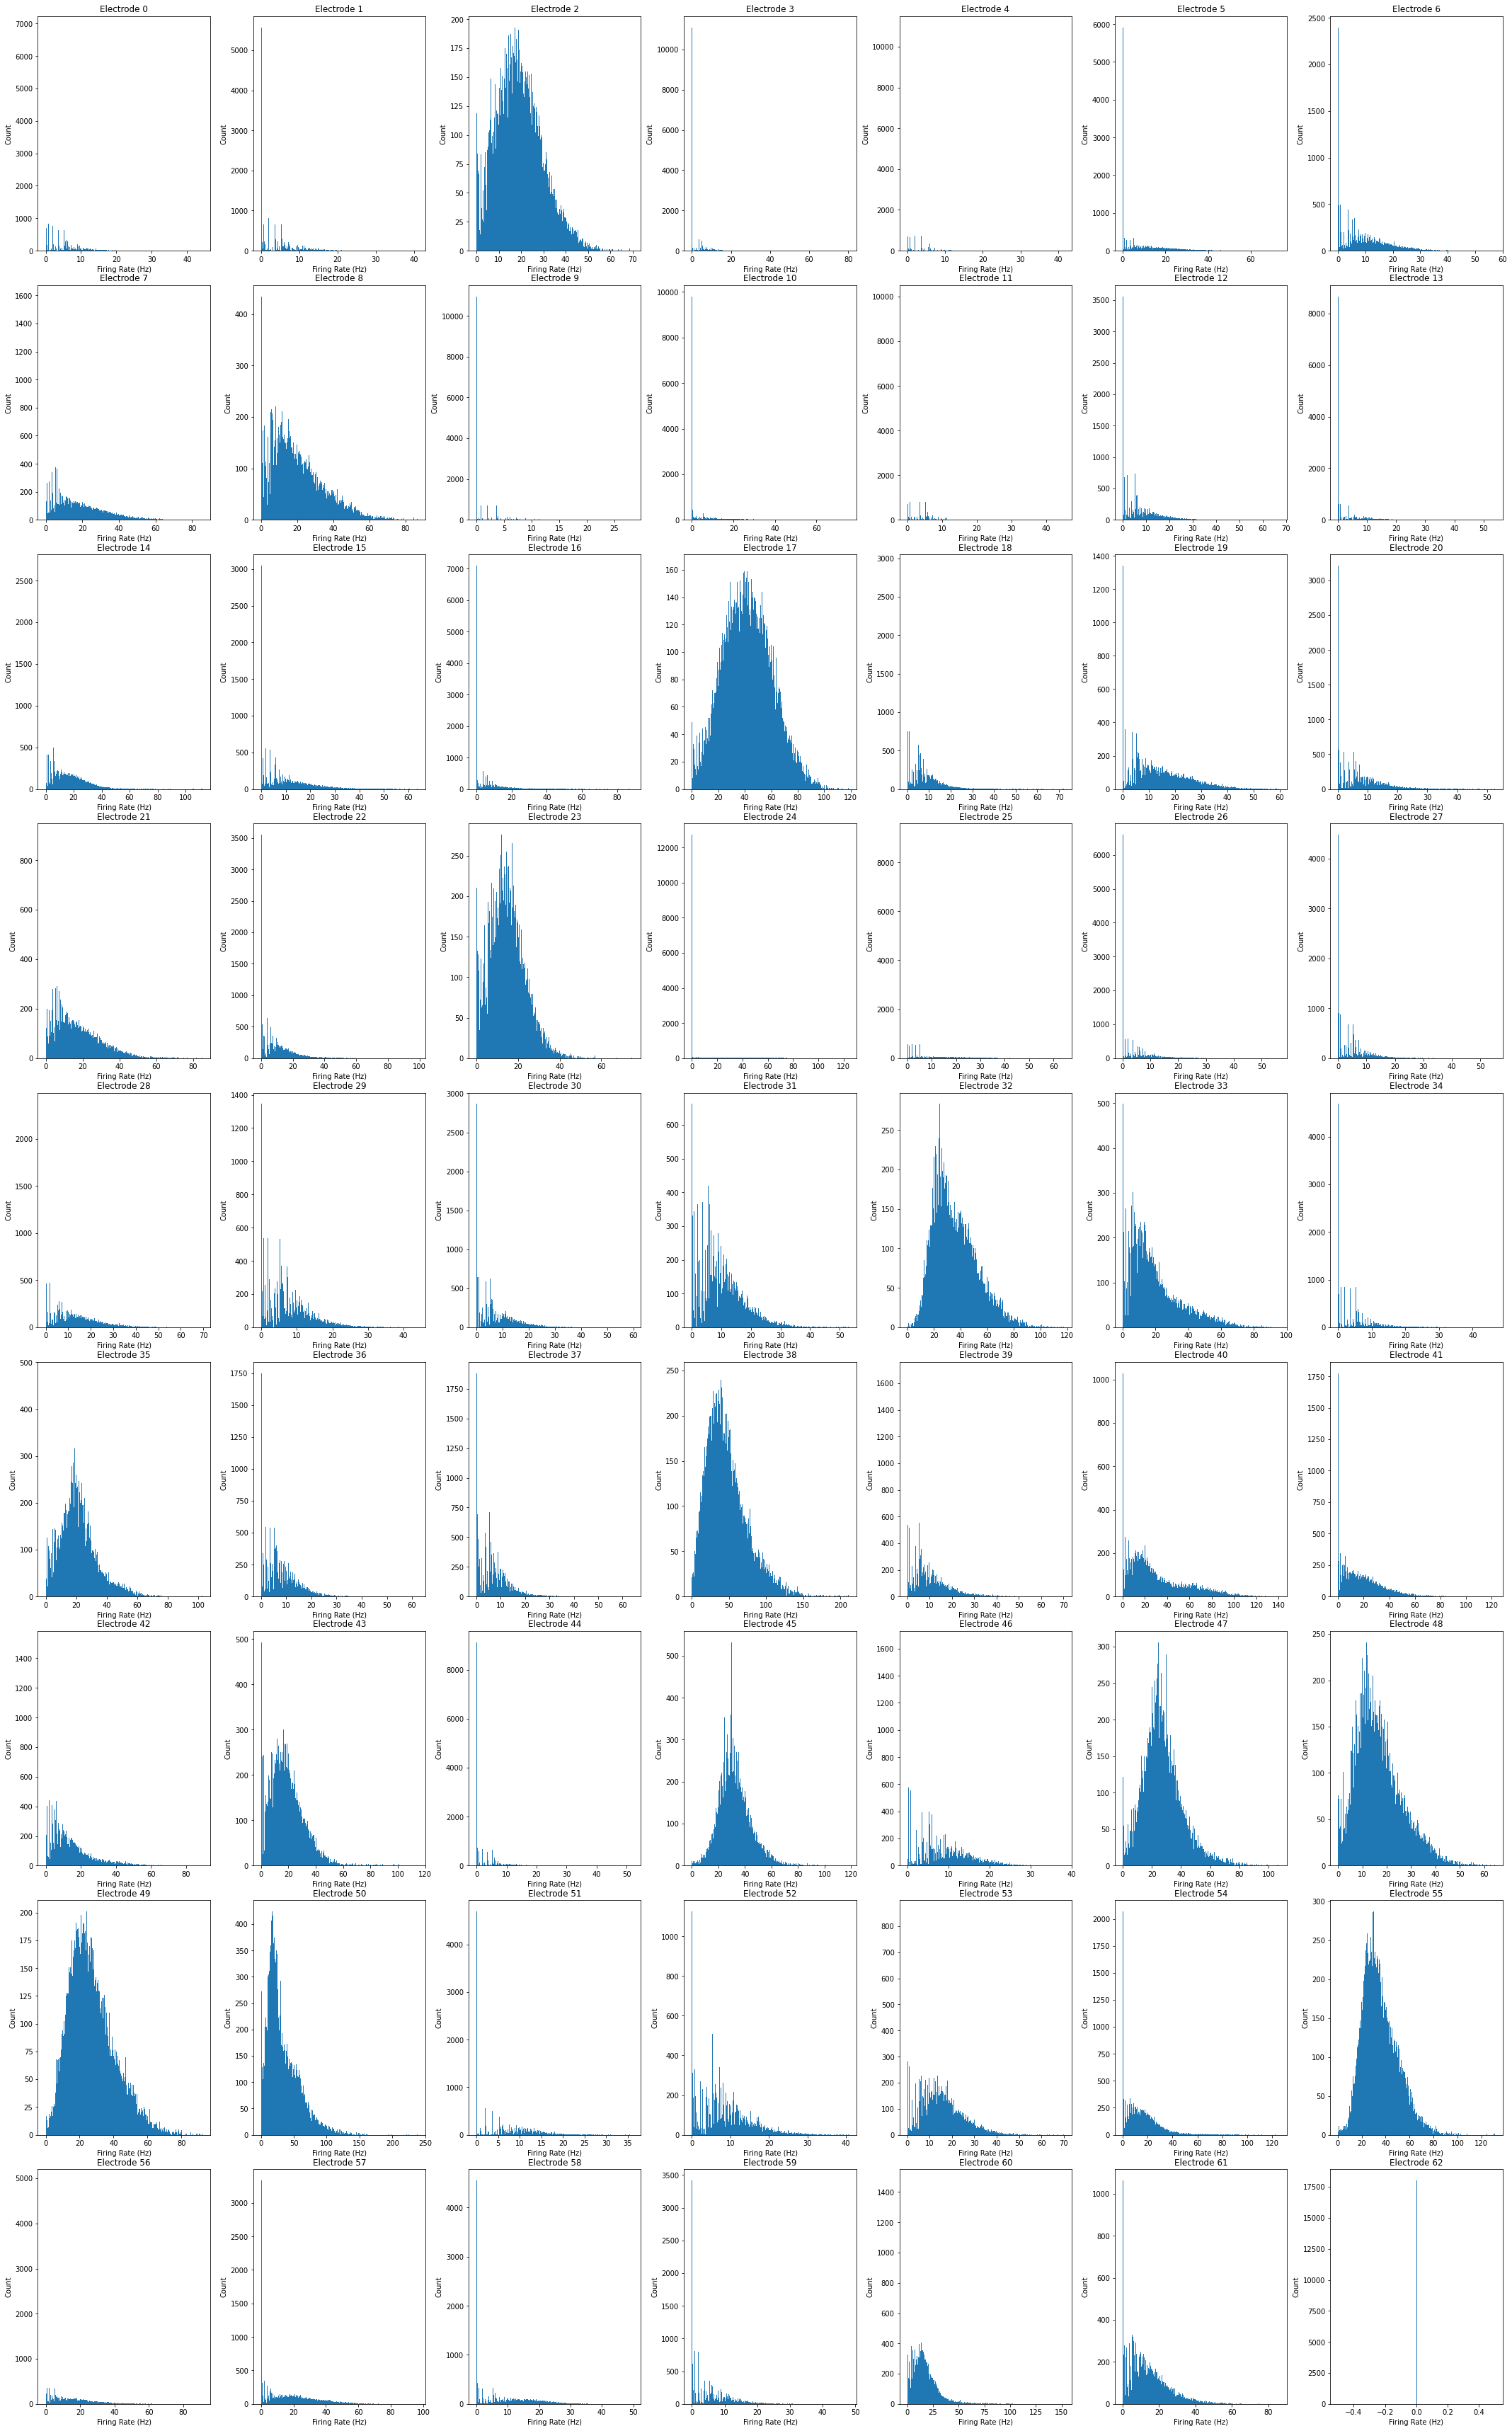

Below 100 Hz is generally indicative of good data quality.


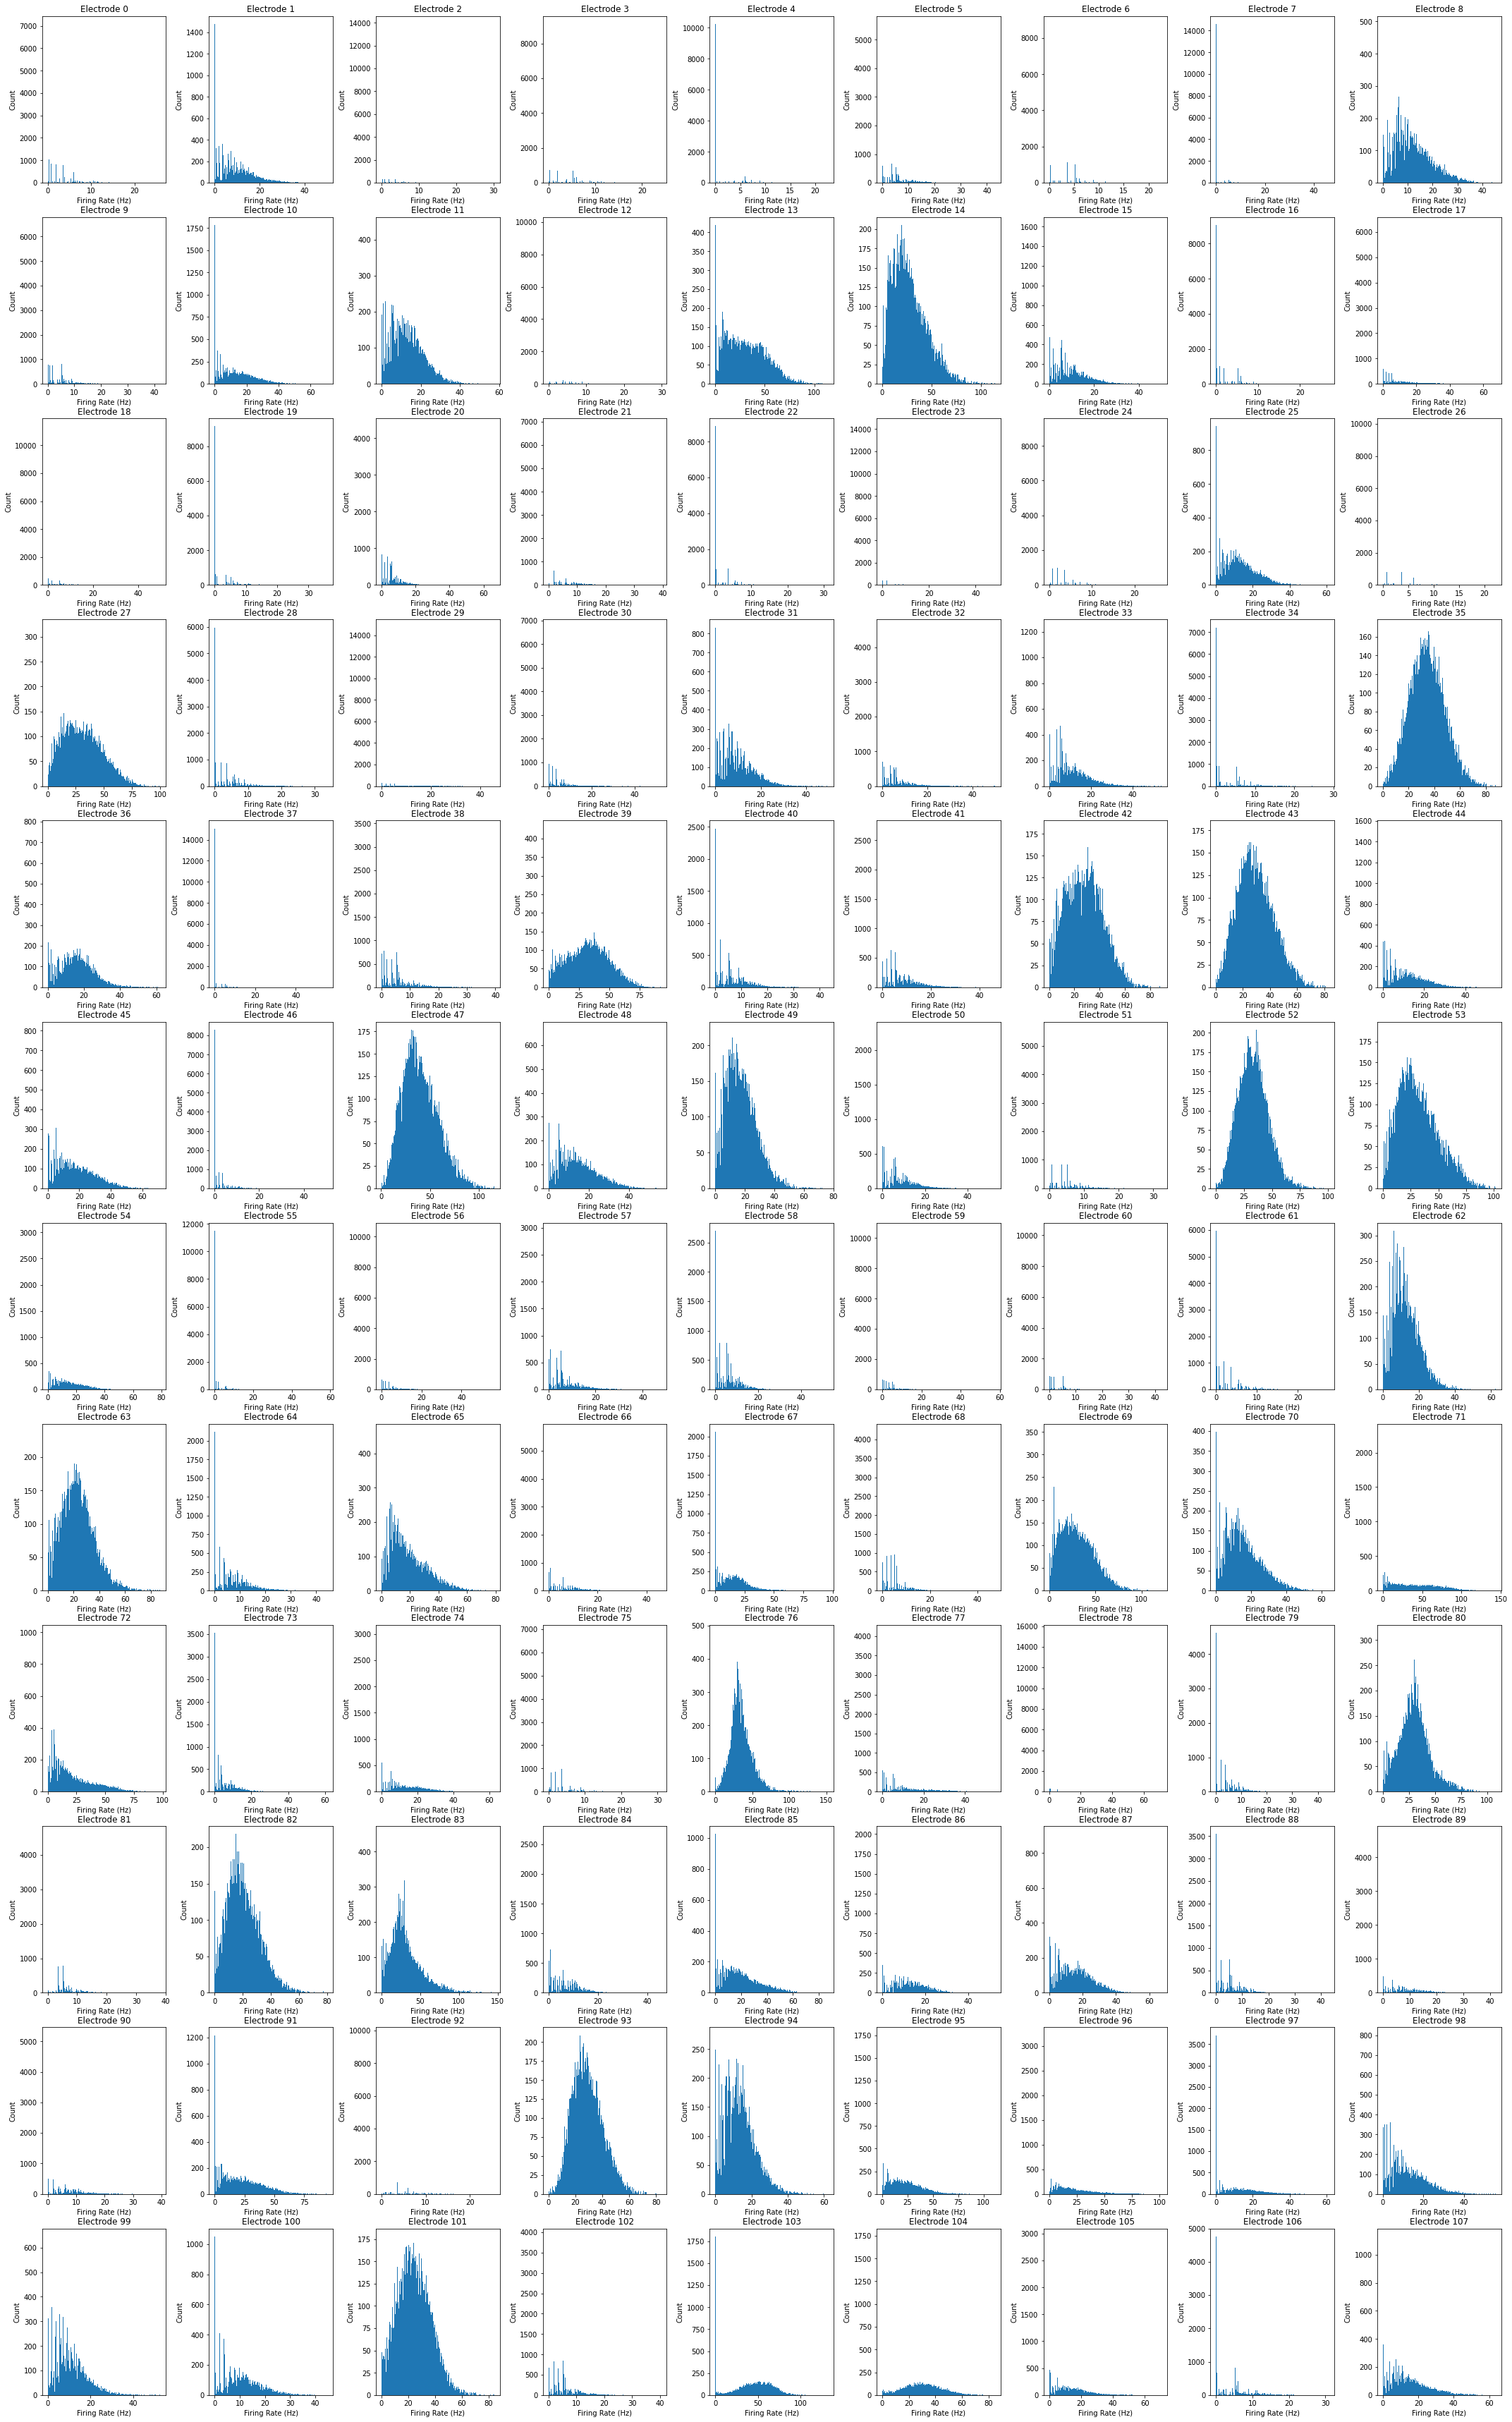

In [ ]:
hist_shapes_list = [(9,5),(9,7),(9,7),(12,9)]
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
for i, neuraldata in enumerate(neuraldata_list_nonans):
    nrows, ncols = hist_shapes_list[i]
    visualize_neuraloutputs_histogram(neuraldata, nrows, ncols, (70,30))

In [60]:
jarvispreds_list_nonans[0].shape

(18000, 69)

DATE: 20220203 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (18001, 44) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.4984, Keypoint Position Variance PC2: 0.3177, Variance PC1+PC2: 0.8161
Neural Variance PC1: 0.4939, Neural Variance PC2: 0.0916, Variance PC1+PC2: 0.5855


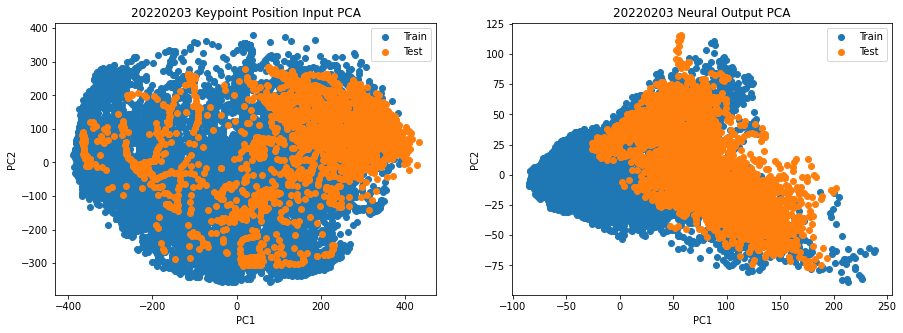



DATE: 20220210_001 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (18001, 62) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.5451, Keypoint Position Variance PC2: 0.3356, Variance PC1+PC2: 0.8807
Neural Variance PC1: 0.2238, Neural Variance PC2: 0.1374, Variance PC1+PC2: 0.36119999999999997


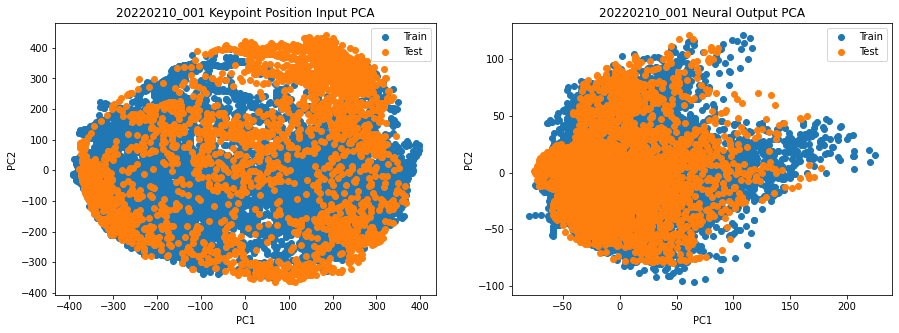



DATE: 20220210_002 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (18001, 62) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.7581, Keypoint Position Variance PC2: 0.1396, Variance PC1+PC2: 0.8976999999999999
Neural Variance PC1: 0.2088, Neural Variance PC2: 0.1394, Variance PC1+PC2: 0.3482


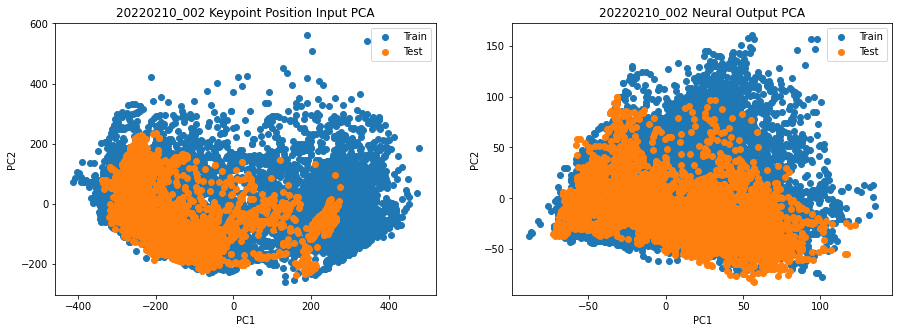



DATE: 20220224 
Neural File Time Duration: 600.0095 
Neural File Spikes Length: (18001, 108) 
Jarvis Preds Length: 18000 
Jarvis Preds num nans: 0

Keypoint Position Variance PC1: 0.6498, Keypoint Position Variance PC2: 0.1839, Variance PC1+PC2: 0.8337000000000001
Neural Variance PC1: 0.2135, Neural Variance PC2: 0.1311, Variance PC1+PC2: 0.3446


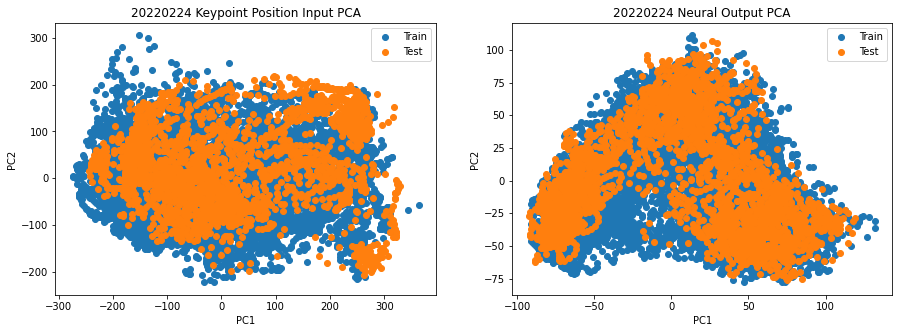

In [62]:
# Visualize data using PCA
for i, (binnedsortedspikes, jarvispred) in enumerate(zip(neuraldata_list_nonans, jarvispreds_list_nonans)):
    date = date_list_nonans[i]
    num_jarv_nans = np.sum(np.isnan(jarvispred))
    print('DATE: {} \nNeural File Time Duration: {} \nNeural File Spikes Length: {} \nJarvis Preds Length: {} \nJarvis Preds num nans: {}\n'\
          .format(date, binnedsortedspikes.get_meta()['duration'], binnedsortedspikes.spike_counts.shape, jarvispred.shape[0], num_jarv_nans))

    # PCA - visualization
    num_instances = jarvispred.shape[0]
    train_split = int(num_instances*.8)

    fig, ax = plt.subplots(nrows = 1, ncols = 2)

    pca_glove = PCA(n_components=2)
    pca_neural = PCA(n_components=2)

    p = np.random.permutation(len(jarvispred))
    pca_glove_features = pca_glove.fit_transform(jarvispred)
    pca_neural_features = pca_neural.fit_transform(binnedsortedspikes.spike_counts)
    # pca_glove_features = pca_glove.fit_transform(jarvispred[p])
    # pca_neural_features = pca_neural.fit_transform(binnedsortedspikes.spike_counts[p])
    
    pca_glove_var = pca_glove.explained_variance_ratio_
    pca_neural_var = pca_neural.explained_variance_ratio_

    pca1_glove_var, pca2_glove_var = round(pca_glove_var[0],4), round(pca_glove_var[1],4)
    pca1_neural_var, pca2_neural_var = round(pca_neural_var[0],4), round(pca_neural_var[1],4)

    print('Keypoint Position Variance PC1: {}, Keypoint Position Variance PC2: {}, Variance PC1+PC2: {}'.format(pca1_glove_var, pca2_glove_var, pca1_glove_var+pca2_glove_var))
    print('Neural Variance PC1: {}, Neural Variance PC2: {}, Variance PC1+PC2: {}'.format(pca1_neural_var, pca2_neural_var, pca1_neural_var+pca2_neural_var))
    
    fig.set_size_inches(15, 5)
    ax[0].scatter(pca_glove_features[:train_split,0], pca_glove_features[:train_split,1], label='Train')
    ax[0].scatter(pca_glove_features[train_split:,0], pca_glove_features[train_split:,1], label='Test')

    ax[1].scatter(pca_neural_features[:train_split,0], pca_neural_features[:train_split,1],label='Train')
    ax[1].scatter(pca_neural_features[train_split:,0], pca_neural_features[train_split:,1], label='Test')

    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC2')

    ax[0].set_title('{} Keypoint Position Input PCA'.format(date))
    ax[1].set_title('{} Neural Output PCA'.format(date))

    ax[0].legend()
    ax[1].legend()

    plt.show()

    print('\n')

In [ ]:
# Next steps
# Trim off last neural frame
# Reshape each video/session so the length of each "trial" is 100

#Proof we want order = 'C'
x = np.array([[1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4],[1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]])
x.reshape((-1,4,4), order = 'C')

array([[[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]],

       [[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]]])

# Create Datasets

In [18]:
index_dict = {'20220203': 0, '20220210_001': 1, '20220210_002': 2, '20220224': 3}

In [19]:
class CustomDataset(Dataset):
    def __init__(self, date, center_inputs = False, normalize_inputs = False, smooth_inputs = False, shuffle = False, convert_keypoints_to_angles = False, velocity = False, conv = True):
        self.date = date
        self.inputs = jarvispreds_list_nonans[index_dict[date]]
        self.input_dim = self.inputs.shape[-1]
        #remove last instance, as neural data has 1 too many instances after binning/smoothing
        neuraldata = neuraldata_list_nonans[index_dict[date]].spike_counts[:-1,:]
        self.num_neural_units = neuraldata.shape[1]
        self.neuraloutputs = neuraldata.reshape((-1, 100, self.num_neural_units), order = 'C') #I checked. We want order C
        self.sample_nums = np.arange(len(self.inputs)/100).astype(int)

        self.center_inputs = center_inputs
        self.normalize_inputs = normalize_inputs
        self.smooth_inputs = smooth_inputs
        self.shuffle = shuffle
        self.convert_keypoints_to_angles = convert_keypoints_to_angles
        self.velocity = velocity
        self.conv = conv

        def center(inp):
            # normalize by subtracting palm coordinates
            palm_x, palm_y, palm_z = inp[:,60], inp[:,61], inp[:,62]
            centered_inputs = []
            i = 0
            while i <= 66:
                feature_x, feature_y, feature_z = inp[:, i], inp[:, i+1], inp[:, i+2]
                feature_x_centered, feature_y_centered, feature_z_centered = feature_x-palm_x, feature_y-palm_y, feature_z-palm_z
                centered_inputs.append(feature_x_centered)
                centered_inputs.append(feature_y_centered)
                centered_inputs.append(feature_z_centered)
                i += 3
            
            centered_inputs_arr = np.asarray(centered_inputs).T
            return(centered_inputs_arr)

        def normalize(inp):
            mean = np.mean(inp, axis = 0)
            var = np.var(inp, axis = 0)
            normalized_inp = (inp-mean)/var
            return(normalized_inp)
        
        def smooth(input, bin_size = 1/30, kernel_type='gaussian', kernel_SD=1/15):
            inp = input.T.tolist()
            smoothed = [] #create new list for smoothed spike counts
            kernel_hl = 3 * int( kernel_SD / bin_size ) #this will be 3x2=6
            normalDistribution = stats.norm(0, kernel_SD)
            x = np.arange(-kernel_hl*bin_size, (kernel_hl+1)*bin_size, bin_size) #create array that goes from -kernel_hl*bin_size to kernel_hl*bin_size, distance between each data points is bin_size
            kernel = normalDistribution.pdf(x) 
            if kernel_type == 'gaussian':
                pass
            elif kernel_type == 'half_gaussian':
                for i in range(0, int(kernel_hl)):
                    kernel[i] = 0
            n_sample = np.size(inp[0])
            nm = np.convolve(kernel, np.ones((n_sample))).T[int(kernel_hl):n_sample + int(kernel_hl)] 
            for each in inp:
                temp1 = np.convolve(kernel,each)
                temp2 = temp1[int(kernel_hl):n_sample + int(kernel_hl)]/nm
                smoothed.append(temp2)
            smoothed_array = np.asarray(smoothed).T
            return(smoothed_array)

        def shuffle_data(inputs, targets, samp_nums):
            assert len(inputs) == len(targets)
            p = np.random.permutation(len(inputs))
            return(inputs[p], targets[p], samp_nums[p])

        if self.center_inputs == True:
            self.inputs = center(self.inputs)
        if self.smooth_inputs == True:
            self.inputs = smooth(self.inputs)
        if self.convert_keypoints_to_angles == True:
            self.input_dim = 15
            self.inputs = joint_angles.get_joint_angles(self.inputs)
        if self.velocity == True:
            self.inputs = joint_angles.get_joint_velocities(self.inputs)
        if self.normalize_inputs == True:
            self.inputs = normalize(self.inputs)
        self.inputs = self.inputs.reshape((-1, 100, self.input_dim), order = 'C')

        if shuffle == True:
            self.inputs, self.neuraloutputs, self.sample_nums =\
             shuffle_data(self.inputs, self.neuraloutputs, self.sample_nums)

    def __len__(self):
        assert len(self.inputs) == len(self.neuraloutputs)
        return len(self.inputs)

    def __getitem__(self, idx):
        input = torch.from_numpy(self.inputs[idx])
        neuraloutput = torch.from_numpy(self.neuraloutputs[idx])
        if self.conv == True:
            return input.float().t(), neuraloutput.float() #input is transposed for convenience - better for Conv1D
        else:
            return input.float(), neuraloutput.float()

In [20]:
dataset20220203 = CustomDataset('20220203', center_inputs = True, smooth_inputs = True)
dataset20220210_001 = CustomDataset('20220210_001', center_inputs = True, smooth_inputs = True)
dataset20220210_002 = CustomDataset('20220210_002', center_inputs = True, smooth_inputs = True)
dataset20220224 = CustomDataset('20220224', center_inputs = True, smooth_inputs = True)

dataset20220203_unsmoothed = CustomDataset('20220203', center_inputs = True)
dataset20220210_001_unsmoothed = CustomDataset('20220210_001', center_inputs = True)
dataset20220210_002_unsmoothed = CustomDataset('20220210_002', center_inputs = True)
dataset20220224_unsmoothed = CustomDataset('20220224', center_inputs = True)

dataset20220203_uncentered_unsmoothed = CustomDataset('20220203')
dataset20220210_001_uncentered_unsmoothed = CustomDataset('20220210_001')
dataset20220210_002_uncentered_unsmoothed = CustomDataset('20220210_002')
dataset20220224_uncentered_unsmoothed = CustomDataset('20220224')

dataset_list = [dataset20220203,dataset20220210_001,dataset20220210_002,dataset20220224]
dataset_list_unsmoothed = [dataset20220203_unsmoothed,dataset20220210_001_unsmoothed,dataset20220210_002_unsmoothed,dataset20220224_unsmoothed]
dataset_list_uncentered_unsmoothed = [dataset20220203_uncentered_unsmoothed,dataset20220210_001_uncentered_unsmoothed,dataset20220210_002_uncentered_unsmoothed,dataset20220224_uncentered_unsmoothed]

In [21]:
joints_dataset20220203 = CustomDataset('20220203', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True)
joints_dataset20220210_001 = CustomDataset('20220210_001', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True)
joints_dataset20220210_002 = CustomDataset('20220210_002', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True)
joints_dataset20220224 = CustomDataset('20220224', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True)

joint_velocities_dataset20220203 = CustomDataset('20220203', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True)
joint_velocities_dataset20220210_001 = CustomDataset('20220210_001', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True)
joint_velocities_dataset20220210_002 = CustomDataset('20220210_002', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True)
joint_velocities_dataset20220224 = CustomDataset('20220224', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True)

joints_dataset_list = [joints_dataset20220203,joints_dataset20220210_001,joints_dataset20220210_002,joints_dataset20220224]
joint_velocities_dataset_list = [joint_velocities_dataset20220203,joint_velocities_dataset20220210_001,joint_velocities_dataset20220210_002,joint_velocities_dataset20220224]

In [22]:
mlp_dataset20220203 = CustomDataset('20220203', center_inputs = True, smooth_inputs = True, shuffle = True, conv = False)
mlp_dataset20220210_001 = CustomDataset('20220210_001', center_inputs = True, smooth_inputs = True, shuffle = True, conv = False)
mlp_dataset20220210_002 = CustomDataset('20220210_002', center_inputs = True, smooth_inputs = True, shuffle = True, conv = False)
mlp_dataset20220224 = CustomDataset('20220224', center_inputs = True, smooth_inputs = True, shuffle = True, conv = False)
mlp_joint_velocities_dataset20220203 = CustomDataset('20220203', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, conv = False)
mlp_joint_velocities_dataset20220210_001 = CustomDataset('20220210_001', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, conv = False)
mlp_joint_velocities_dataset20220210_002 = CustomDataset('20220210_002', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, conv = False)
mlp_joint_velocities_dataset20220224 = CustomDataset('20220224', center_inputs = True, smooth_inputs = True, convert_keypoints_to_angles=True, velocity = True, shuffle = True, conv = False)
mlp_dataset_list = [mlp_dataset20220203,mlp_dataset20220210_001,mlp_dataset20220210_002,mlp_dataset20220224,mlp_joint_velocities_dataset20220203,mlp_joint_velocities_dataset20220210_001,mlp_joint_velocities_dataset20220210_002,mlp_joint_velocities_dataset20220224,]

In [23]:
#input is transposed for convenience - better for Conv1D
for dataset in dataset_list:
  print(('{} \nnum instances: {} \nJarvis input shape: {} \nNeural Spikes shape: {}\n').\
        format(dataset.date, len(dataset), dataset[0][0].shape, dataset[0][1].shape))

20220203 
num instances: 180 
Jarvis input shape: torch.Size([69, 100]) 
Neural Spikes shape: torch.Size([100, 44])

20220210_001 
num instances: 180 
Jarvis input shape: torch.Size([69, 100]) 
Neural Spikes shape: torch.Size([100, 62])

20220210_002 
num instances: 180 
Jarvis input shape: torch.Size([69, 100]) 
Neural Spikes shape: torch.Size([100, 62])

20220224 
num instances: 180 
Jarvis input shape: torch.Size([69, 100]) 
Neural Spikes shape: torch.Size([100, 108])



In [24]:
#input is transposed for convenience - better for Conv1D
for dataset in joints_dataset_list:
  print(('{} \nnum instances: {} \nJoint input shape: {} \nNeural Spikes shape: {}\n').\
        format(dataset.date, len(dataset), dataset[0][0].shape, dataset[0][1].shape))

20220203 
num instances: 180 
Joint input shape: torch.Size([15, 100]) 
Neural Spikes shape: torch.Size([100, 44])

20220210_001 
num instances: 180 
Joint input shape: torch.Size([15, 100]) 
Neural Spikes shape: torch.Size([100, 62])

20220210_002 
num instances: 180 
Joint input shape: torch.Size([15, 100]) 
Neural Spikes shape: torch.Size([100, 62])

20220224 
num instances: 180 
Joint input shape: torch.Size([15, 100]) 
Neural Spikes shape: torch.Size([100, 108])



In [25]:
#input is transposed for convenience - better for Conv1D
for dataset in mlp_dataset_list:
  print(('{} \nnum instances: {} \nInput shape: {} \nNeural Spikes shape: {}\n').\
        format(dataset.date, len(dataset), dataset[0][0].shape, dataset[0][1].shape))

20220203 
num instances: 180 
Input shape: torch.Size([100, 69]) 
Neural Spikes shape: torch.Size([100, 44])

20220210_001 
num instances: 180 
Input shape: torch.Size([100, 69]) 
Neural Spikes shape: torch.Size([100, 62])

20220210_002 
num instances: 180 
Input shape: torch.Size([100, 69]) 
Neural Spikes shape: torch.Size([100, 62])

20220224 
num instances: 180 
Input shape: torch.Size([100, 69]) 
Neural Spikes shape: torch.Size([100, 108])

20220203 
num instances: 180 
Input shape: torch.Size([100, 15]) 
Neural Spikes shape: torch.Size([100, 44])

20220210_001 
num instances: 180 
Input shape: torch.Size([100, 15]) 
Neural Spikes shape: torch.Size([100, 62])

20220210_002 
num instances: 180 
Input shape: torch.Size([100, 15]) 
Neural Spikes shape: torch.Size([100, 62])

20220224 
num instances: 180 
Input shape: torch.Size([100, 15]) 
Neural Spikes shape: torch.Size([100, 108])



In [26]:
torch.manual_seed(1)

train_loader_uncentered_unsmoothed_list = []
test_loader_uncentered_unsmoothed_list = []
toy_loader_uncentered_unsmoothed_list = []
train_loader_unsmoothed_list = []
test_loader_unsmoothed_list = []
toy_loader_unsmoothed_list = []
train_loader_list = []
test_loader_list = []
toy_loader_list = []
train_joints_loader_list = []
test_joints_loader_list = []
toy_joints_loader_list = []
train_joint_velocities_loader_list = []
test_joint_velocities_loader_list = []
toy_joint_velocities_loader_list = []

toy_dataset_uncentered_unsmoothed_list = []
toy_dataset_unsmoothed_list = []
toy_dataset_list = []
toy_joints_dataset_list = []
toy_joint_velocities_dataset_list = []

# 60/20/20 split for each session
for i, (dataset, dataset_unsmoothed, dataset_uncentered_unsmoothed, joints_dataset, joint_velocities_dataset) in \
 enumerate(zip(dataset_list, dataset_list_unsmoothed, dataset_list_uncentered_unsmoothed, joints_dataset_list, joint_velocities_dataset_list)):
    num_instances = len(dataset)
    train_split = int(num_instances*.8)

    train_dataset = Subset(dataset, np.arange(num_instances)[:train_split])
    test_dataset = Subset(dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset = Subset(dataset, np.arange(num_instances)[:4])

    train_dataset_unsmoothed = Subset(dataset_unsmoothed, np.arange(num_instances)[:train_split])
    test_dataset_unsmoothed = Subset(dataset_unsmoothed, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset_unsmoothed = Subset(dataset_unsmoothed, np.arange(num_instances)[:4])

    train_dataset_uncentered_unsmoothed = Subset(dataset_uncentered_unsmoothed, np.arange(num_instances)[:train_split])
    test_dataset_uncentered_unsmoothed = Subset(dataset_uncentered_unsmoothed, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset_uncentered_unsmoothed = Subset(dataset_uncentered_unsmoothed, np.arange(num_instances)[:4])

    train_joints_dataset = Subset(joints_dataset, np.arange(num_instances)[:train_split])
    test_joints_dataset = Subset(joints_dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_joints_dataset = Subset(joints_dataset, np.arange(num_instances)[:4])

    train_joint_velocities_dataset = Subset(joint_velocities_dataset, np.arange(num_instances)[:train_split])
    test_joint_velocities_dataset = Subset(joint_velocities_dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_joint_velocities_dataset = Subset(joint_velocities_dataset, np.arange(num_instances)[:4])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, pin_memory=True, sampler=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, pin_memory=True)
    toy_loader = torch.utils.data.DataLoader(toy_dataset, batch_size=4, pin_memory=True)
    train_loader_unsmoothed = torch.utils.data.DataLoader(train_dataset_unsmoothed, batch_size=32, pin_memory=True, sampler=None)
    test_loader_unsmoothed = torch.utils.data.DataLoader(test_dataset_unsmoothed, batch_size=32, pin_memory=True)
    toy_loader_unsmoothed = torch.utils.data.DataLoader(toy_dataset_unsmoothed, batch_size=4, pin_memory=True)
    train_loader_uncentered_unsmoothed = torch.utils.data.DataLoader(train_dataset_uncentered_unsmoothed, batch_size=32, pin_memory=True, sampler=None)
    test_loader_uncentered_unsmoothed = torch.utils.data.DataLoader(test_dataset_uncentered_unsmoothed, batch_size=32, pin_memory=True)
    toy_loader_uncentered_unsmoothed = torch.utils.data.DataLoader(toy_dataset_uncentered_unsmoothed, batch_size=4, pin_memory=True)
    train_joints_loader = torch.utils.data.DataLoader(train_joints_dataset, batch_size=32, pin_memory=True, sampler=None)
    test_joints_loader = torch.utils.data.DataLoader(test_joints_dataset, batch_size=32, pin_memory=True)
    toy_joints_loader = torch.utils.data.DataLoader(toy_joints_dataset, batch_size=4, pin_memory=True)
    train_joint_velocities_loader = torch.utils.data.DataLoader(train_joint_velocities_dataset, batch_size=32, pin_memory=True, sampler=None)
    test_joint_velocities_loader = torch.utils.data.DataLoader(test_joint_velocities_dataset, batch_size=32, pin_memory=True)
    toy_joint_velocities_loader = torch.utils.data.DataLoader(toy_joint_velocities_dataset, batch_size=4, pin_memory=True)

    train_loader_list.append(train_loader)
    test_loader_list.append(test_loader)
    toy_loader_list.append(toy_loader)
    train_loader_unsmoothed_list.append(train_loader_unsmoothed)
    test_loader_unsmoothed_list.append(test_loader_unsmoothed)
    toy_loader_unsmoothed_list.append(toy_loader_unsmoothed)
    train_loader_uncentered_unsmoothed_list.append(train_loader_uncentered_unsmoothed)
    test_loader_uncentered_unsmoothed_list.append(test_loader_uncentered_unsmoothed)
    toy_loader_uncentered_unsmoothed_list.append(toy_loader_uncentered_unsmoothed)
    train_joints_loader_list.append(train_joints_loader)
    test_joints_loader_list.append(test_joints_loader)
    toy_joints_loader_list.append(toy_joints_loader)
    train_joint_velocities_loader_list.append(train_joint_velocities_loader)
    test_joint_velocities_loader_list.append(test_joint_velocities_loader)
    toy_joint_velocities_loader_list.append(toy_joint_velocities_loader)

    toy_dataset = Subset(dataset, np.arange(num_instances)[:1])
    toy_dataset_unsmoothed = Subset(dataset_unsmoothed, np.arange(num_instances)[:1])
    toy_dataset_uncentered_unsmoothed = Subset(dataset_uncentered_unsmoothed, np.arange(num_instances)[:1])
    toy_joints_dataset = Subset(joints_dataset, np.arange(num_instances)[:1])
    toy_joint_velocities_dataset = Subset(joint_velocities_dataset, np.arange(num_instances)[:1])
    toy_dataset_list.append(toy_dataset)
    toy_dataset_unsmoothed_list.append(toy_dataset_unsmoothed)
    toy_dataset_uncentered_unsmoothed_list.append(toy_dataset_uncentered_unsmoothed)
    toy_joints_dataset_list.append(toy_joints_dataset)
    toy_joint_velocities_dataset_list.append(toy_joint_velocities_dataset)

    print('Date: {}'.format(dataset.date))
    print('Total dataset size: {}'.format(len(dataset)))
    print('Number of train instances: {}, Number of test instances: {}'\
          .format(len(train_dataset), len(test_dataset)))

Date: 20220203
Total dataset size: 180
Number of train instances: 144, Number of test instances: 36
Date: 20220210_001
Total dataset size: 180
Number of train instances: 144, Number of test instances: 36
Date: 20220210_002
Total dataset size: 180
Number of train instances: 144, Number of test instances: 36
Date: 20220224
Total dataset size: 180
Number of train instances: 144, Number of test instances: 36


In [27]:
train_loader_mlp_list = []
test_loader_mlp_list = []
toy_loader_mlp_list = []

for i, (dataset) in enumerate(mlp_dataset_list):
    num_instances = len(dataset)
    train_split = int(num_instances*.8)
    train_dataset = Subset(dataset, np.arange(num_instances)[:train_split])
    test_dataset = Subset(dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset = Subset(dataset, np.arange(num_instances)[:4])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, pin_memory=True, sampler=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, pin_memory=True)
    toy_loader = torch.utils.data.DataLoader(toy_dataset, batch_size=4, pin_memory=True)

    train_loader_mlp_list.append(train_loader)
    test_loader_mlp_list.append(test_loader)
    toy_loader_mlp_list.append(toy_loader)

# Building and Training Model

In [34]:
class TempConvNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_conv_layers, num_readout_layers, kernel_size, filters_per_conv, causal):
        super(TempConvNet, self).__init__()
        self.net = nn.ModuleList()
        assert num_conv_layers >= 1
        self.num_conv_layers = num_conv_layers
        self.num_readout_layers = num_readout_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.causal = causal
        if self.causal == True:
            self.padding = kernel_size-1
        else:
            self.padding = 'same'
        
        # 1D convolutional layers
        for i in range(num_conv_layers):
            self.net.append(nn.Conv1d(in_channels = input_dim, out_channels = input_dim*filters_per_conv, \
                                      kernel_size = kernel_size, padding = self.padding))
            self.net.append(nn.ReLU())
            input_dim *= filters_per_conv

        # output layer
        self.net.append(nn.Linear(input_dim, output_dim))
        if num_readout_layers > 1:
            for i in range(num_readout_layers-1):
                self.net.append(nn.ReLU())
                self.net.append(nn.Linear(output_dim, output_dim))
    
    def forward(self, x):
        for i, layer in enumerate(self.net):
            shape_before = x.shape
            if (type(layer)==torch.nn.modules.linear.Linear) and (i==(len(self.net)-(2*self.num_readout_layers-1))):
                x = layer(torch.transpose(x, 1, 2))
            elif ((type(layer)==torch.nn.modules.conv.Conv1d) and (self.causal == True)):
                x = layer(x)
                x = x[:, :, :-layer.padding[0]]
            else:
                x = layer(x)
            shape_after = x.shape
            print('Layer {} Shape before: {}, Shape after: {}'.format(i, shape_before, shape_after))
        return(x)

In [35]:
x = torch.rand((32,15,100))
m = TempConvNet(15, 65, 2, 1, 5, 2, False)

In [36]:
m

TempConvNet(
  (net): ModuleList(
    (0): Conv1d(15, 30, kernel_size=(5,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(30, 60, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=65, bias=True)
  )
)

In [38]:
y = m(x)

Layer 0 Shape before: torch.Size([32, 15, 100]), Shape after: torch.Size([32, 30, 100])
Layer 1 Shape before: torch.Size([32, 30, 100]), Shape after: torch.Size([32, 30, 100])
Layer 2 Shape before: torch.Size([32, 30, 100]), Shape after: torch.Size([32, 60, 100])
Layer 3 Shape before: torch.Size([32, 60, 100]), Shape after: torch.Size([32, 60, 100])
Layer 4 Shape before: torch.Size([32, 60, 100]), Shape after: torch.Size([32, 100, 65])


In [29]:
class FCNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_layer_dim):
        super(FCNet, self).__init__()
        self.net = nn.ModuleList()
        assert num_layers >= 2
        self.num_layers = num_layers
        self.hidden_layer_dim = hidden_layer_dim

        if type(hidden_layer_dim == int):
            # input layer
            self.net.append(nn.Linear(input_dim, hidden_layer_dim))
            self.net.append(nn.ReLU())
            # hidden layers
            for i in range(num_layers-2):
                self.net.append(nn.Linear(hidden_layer_dim, hidden_layer_dim))
                self.net.append(nn.ReLU())
            # output layer
            self.net.append(nn.Linear(hidden_layer_dim, output_dim))
        
        elif type(hidden_layer_dim == list):
            assert len(hidden_layer_dim) == num_layers-1

            self.net.append(nn.Linear(input_dim, hidden_layer_dim[0]))
            self.net.append(nn.ReLU())
            for i in range(len(hidden_layer_dim)-1):
                self.net.append(nn.Linear(hidden_layer_dim[i], hidden_layer_dim[i+1]))
                self.net.append(nn.ReLU())
            self.net.append(nn.Linear(hidden_layer_dim[-1], output_dim))
    
    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return(x)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(loader, model, optimizer, criterion):
    model.train()
    batch_losses = []

    for i, (input, target) in enumerate(loader):
        optimizer.zero_grad() #clear gradient
        input = input.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float)
        
        pred = model(input)
        # print(pred.shape, target.shape)
        loss = criterion(pred, target)  # calculate loss
        mean_batch_loss = loss.item()
        batch_losses.append(mean_batch_loss)

        loss.backward()  # one backward pass
        optimizer.step()  # update the parameters

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)

def test(loader, model, optimizer, criterion):
    model.eval()
    batch_losses = []

    with torch.no_grad():
        for i, (input, target) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)
            pred = model(input)

            loss = criterion(pred, target)  
            mean_batch_loss = loss.item()
            batch_losses.append(mean_batch_loss)

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)

def get_instance_losses(loader, model, criterion = torch.nn.MSELoss(reduction='none'), mlp = False):
    model.eval()
    inputs = []
    targets = []
    preds = []
    losses = []

    with torch.no_grad():
        for i, (input, target) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)

            pred = model(input)
            all_losses_batch = criterion(pred, target)  # calculate loss
            all_losses_batch = all_losses_batch.detach().cpu().data.numpy()
            
            # print(input.shape)
            if mlp == False:
                inputs.append(input.cpu().data.numpy().T)
            else:
                inputs.append(input.cpu().data.numpy())
            targets.append(target.cpu().data.numpy())
            preds.append(pred)
            losses.append(all_losses_batch)

    if mlp == False:
        all_targets = np.vstack(targets)
        all_preds = np.vstack(preds)
    else:
        all_targets = np.vstack(targets).reshape(-1,targets[0].shape[-1])
        all_preds = np.vstack(preds).reshape(-1,targets[0].shape[-1])

    all_inputs = np.vstack(inputs)
    all_losses = np.vstack(losses)
    all_losses = np.mean(all_losses, axis = 1)

    all_data = [all_losses, all_inputs, all_targets, all_preds]
    return(all_data)

In [36]:
def get_psd(sig, nperseg):
    freq, psd = signal.welch(sig, fs=30, nperseg=nperseg)
    return psd[np.argsort(freq)], freq[np.argsort(freq)]

In [74]:
def plot_signal_and_psd(neural = False, joints = False, smoothed = False, centered = False, velocity = False, nperseg = 20):
    if neural == True:
        x = toy_joints_dataset_list[0][0][1].t()
        keypoints_list = ['Electrode {}'.format(i) for i in range(x.shape[0])]
        title = 'Smoothed Neural Firing Rate - first 100 frames'
        ylabel = 'Smoothed Neural Firing Rate'
    else:
        if joints == False:
            keypoints_list = keypoint_list_names
            if centered == False:
                x = toy_dataset_uncentered_unsmoothed_list[0][0][0]
                title = 'Uncentered Unsmoothed Keypoint - first 100 frames'
                ylabel = 'Uncentered Unsmoothed Keypoint'
            elif smoothed == False:
                x = toy_dataset_unsmoothed_list[0][0][0]
                title = 'Centered Unsmoothed Keypoint - first 100 frames'
                ylabel = 'Centered Unsmoothed Keypoint'
            else:
                x = toy_dataset_list[0][0][0]
                title = 'Centered Smoothed Keypoint - first 100 frames'
                ylabel = 'Centered Smoothed Keypoint'
        else:
            keypoints_list = joint_names_list
            if velocity == False:
                x = toy_joints_dataset_list[0][0][0]
                title = 'Smoothed Joint Angle - first 100 frames'
                ylabel = 'Smoothed Joint Angle'
            else:
                x = toy_joint_velocities_dataset_list[0][0][0]
                title = 'Smoothed Joint Velocity - first 100 frames'
                ylabel = 'Smoothed Joint Velocity'
    for i in range(x.shape[0]):
        psd, freq = get_psd(x[i,:], nperseg = nperseg)
        xaxis = np.arange(100)*0.033333
        fig, ax = plt.subplots(nrows = 1, ncols = 2)
        fig.suptitle('Keypoint: {}'.format(keypoints_list[i]))
        fig.set_size_inches(20, 4)
        ax[0].plot(xaxis, x[i,:])
        ax[0].set_xlabel('Time (s)')
        ax[0].set_ylabel(ylabel)
        ax[0].set_title(title)
        ax[1].plot(freq, abs(psd))
        ax[1].set_xlabel('Frequency')
        ax[1].set_ylabel('PSD')
        ax[1].set_title('Corresponding Power Spectrum')
        plt.show()
        ind = np.argpartition(abs(psd), -3)[-3:]
        print('PSD Max coefficient values: {}, Corresponding Frequencies: {}'.format(abs(psd)[ind], freq[ind]))

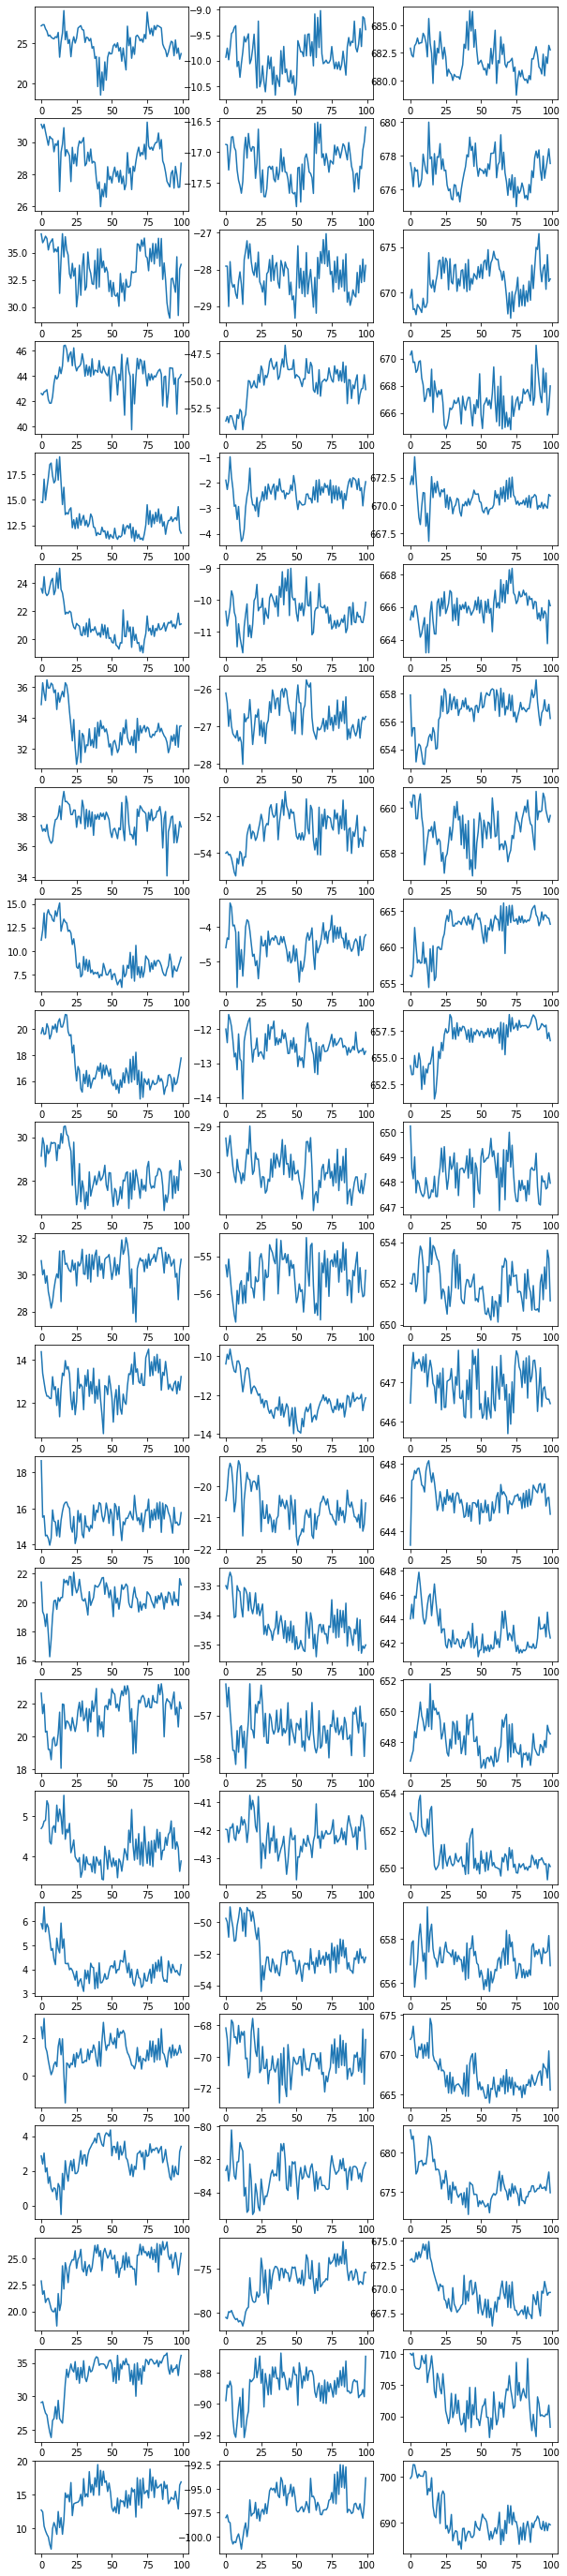

In [61]:
f, ax = plt.subplots(nrows = 23, ncols = 3)
f.set_size_inches(10, 50)
for k in range(69):
    i = k-(int(k/3)*3)
    j = int(k/3)
    ax[j][i].plot(jarvispreds_list_nonans[0][:100,k])
plt.show()

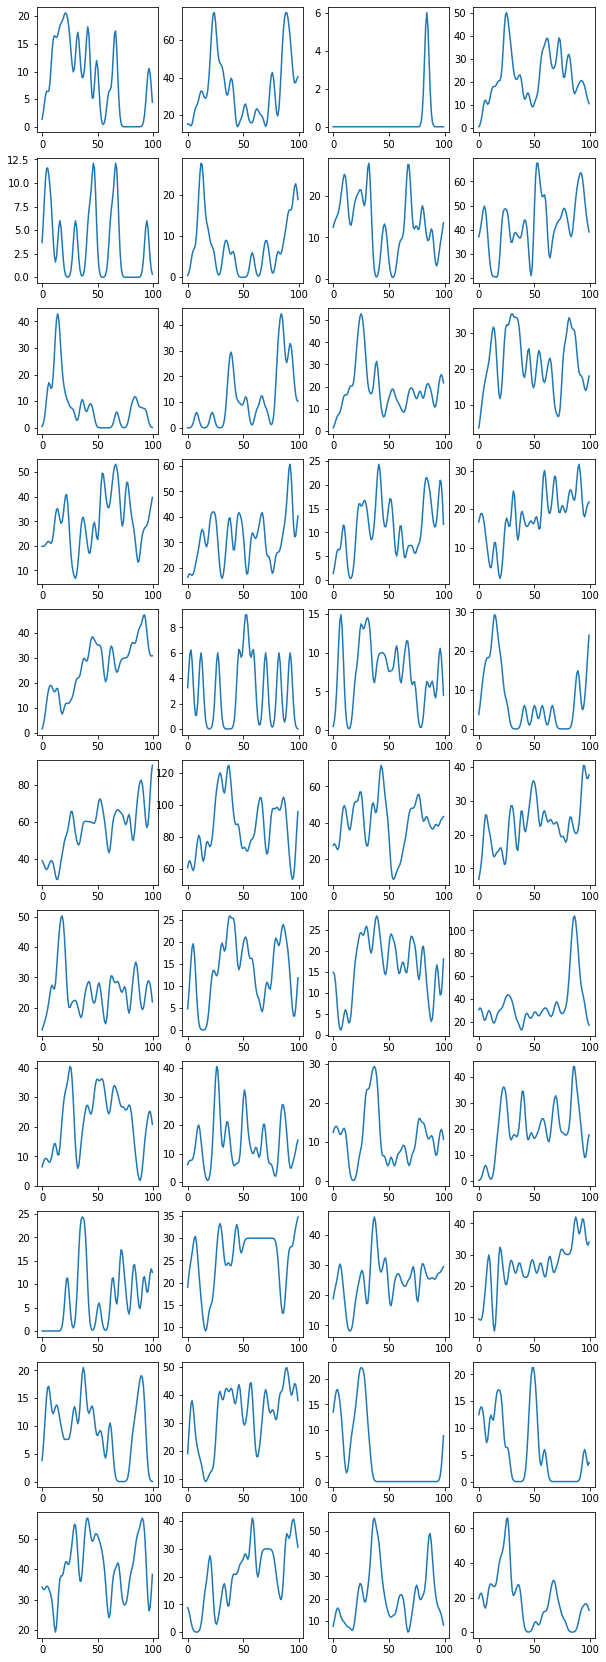

In [68]:
f, ax = plt.subplots(nrows = 11, ncols = 4)
f.set_size_inches(10, 30)
for k in range(44):
    i = k-(int(k/4)*4)
    j = int(k/4)
    ax[j][i].plot(neuraldata_list_nonans[0].spike_counts[:100,k])
plt.show()

In [ ]:
plot_signal_and_psd(joints = False, smoothed = False, centered = False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_signal_and_psd(joints = False, smoothed = False, centered = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_signal_and_psd(joints = False, smoothed = True, centered = True)

Output hidden; open in https://colab.research.google.com to view.

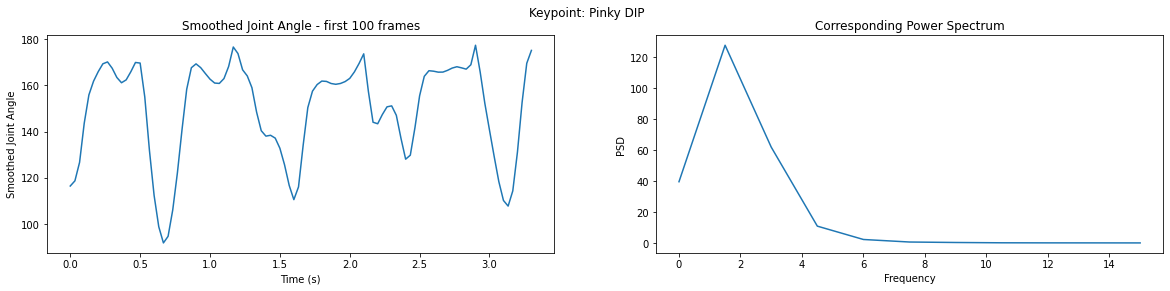

PSD Max coefficient values: [ 39.524826  61.872776 127.64281 ], Corresponding Frequencies: [0.  3.  1.5]


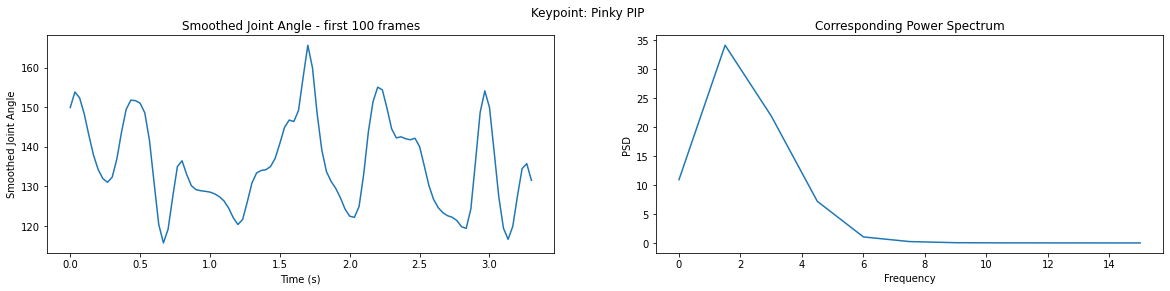

PSD Max coefficient values: [10.923164 21.926552 34.139896], Corresponding Frequencies: [0.  3.  1.5]


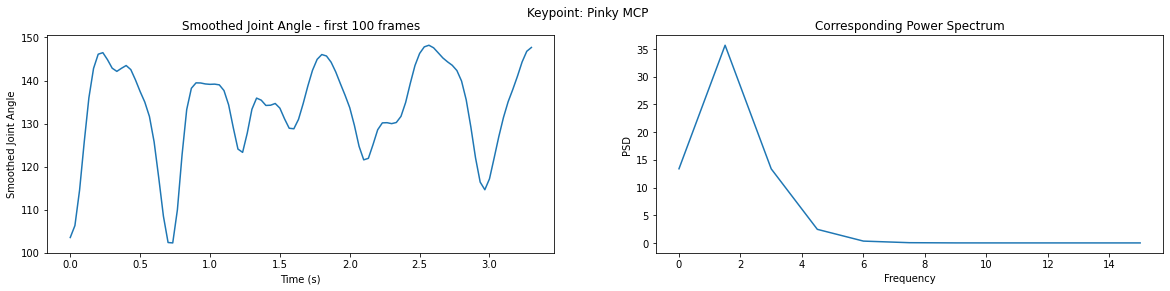

PSD Max coefficient values: [13.365361 13.380894 35.672016], Corresponding Frequencies: [3.  0.  1.5]


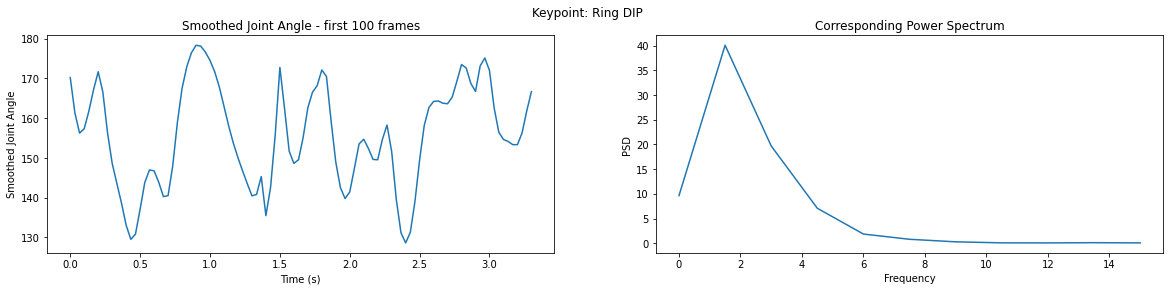

PSD Max coefficient values: [ 9.634116 19.69734  40.11235 ], Corresponding Frequencies: [0.  3.  1.5]


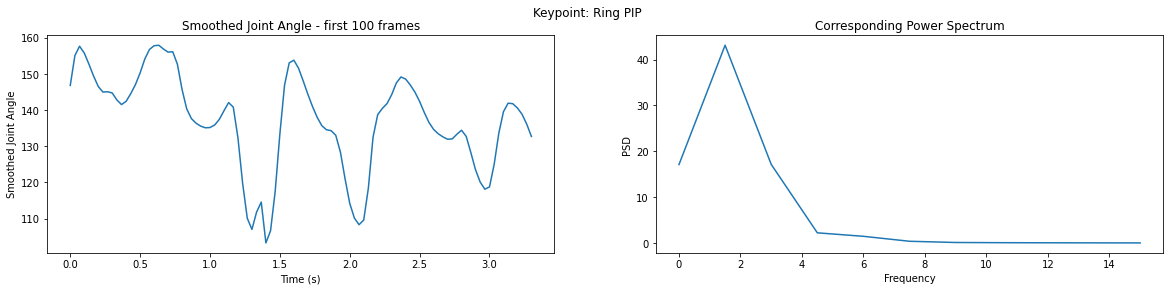

PSD Max coefficient values: [17.102104 17.143188 43.13092 ], Corresponding Frequencies: [0.  3.  1.5]


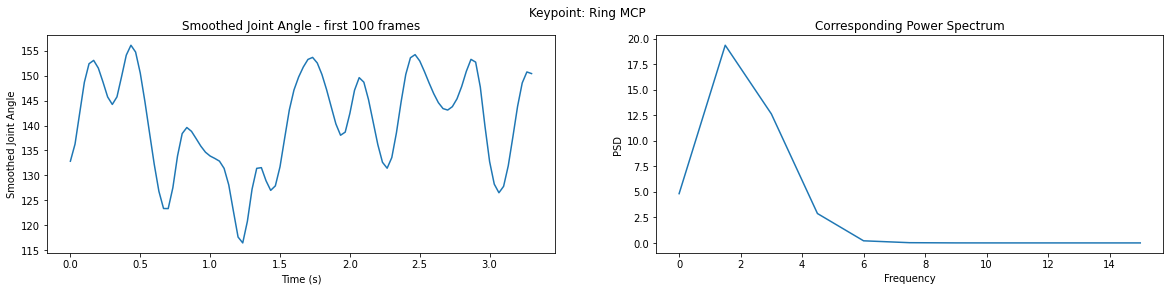

PSD Max coefficient values: [ 4.819493 12.625478 19.343729], Corresponding Frequencies: [0.  3.  1.5]


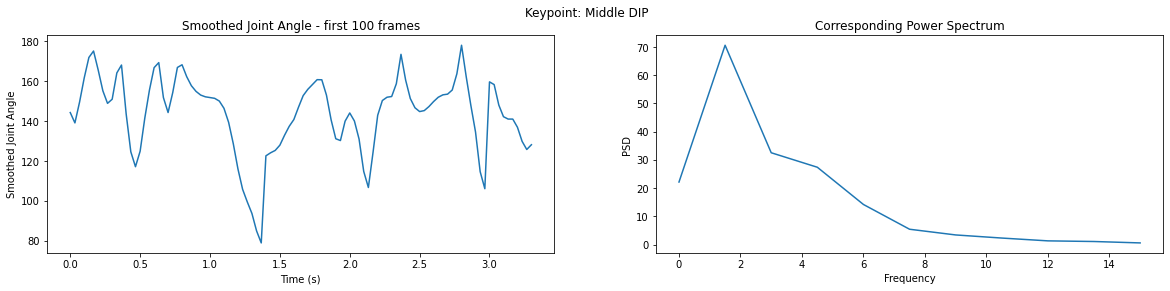

PSD Max coefficient values: [27.382711 32.516617 70.59244 ], Corresponding Frequencies: [4.5 3.  1.5]


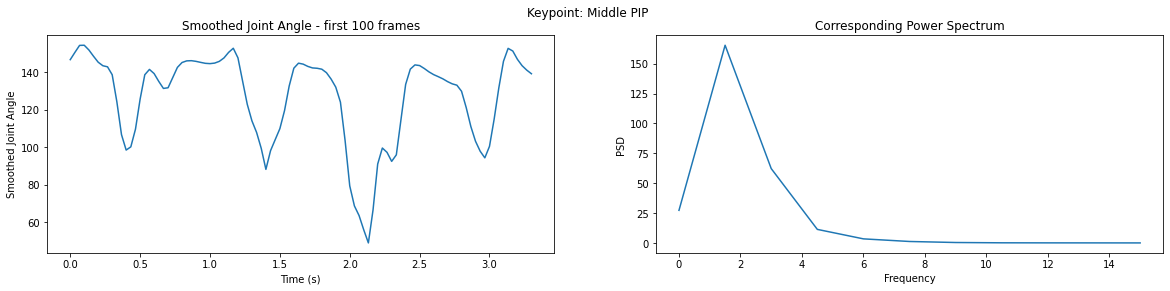

PSD Max coefficient values: [ 27.290653  62.241474 165.48654 ], Corresponding Frequencies: [0.  3.  1.5]


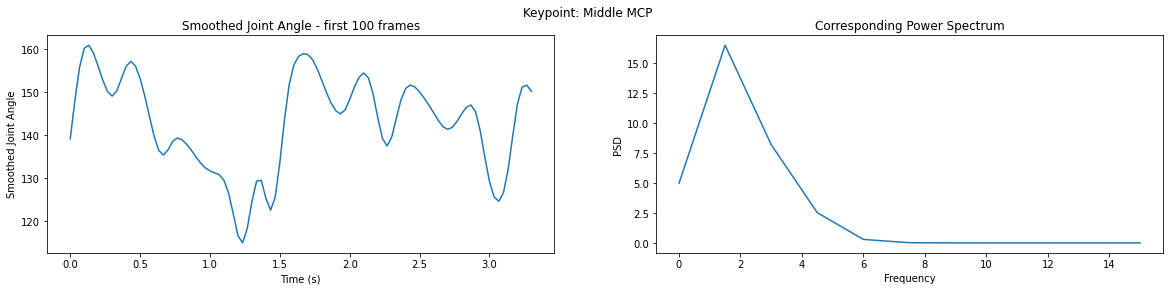

PSD Max coefficient values: [ 4.9666333  8.187382  16.4752   ], Corresponding Frequencies: [0.  3.  1.5]


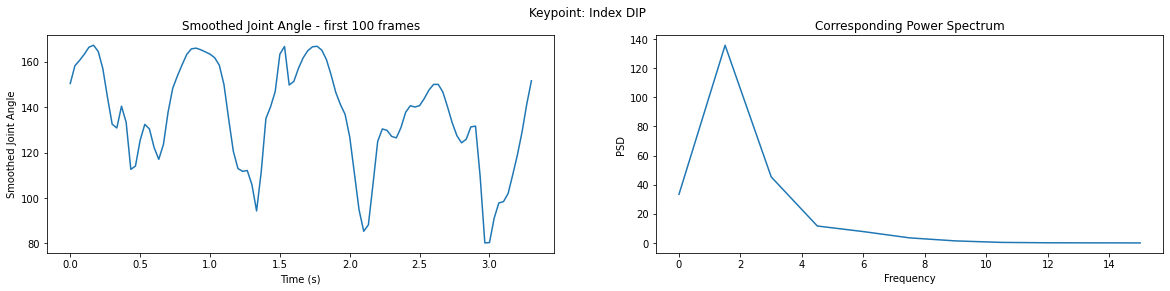

PSD Max coefficient values: [ 33.39399   45.324062 135.68951 ], Corresponding Frequencies: [0.  3.  1.5]


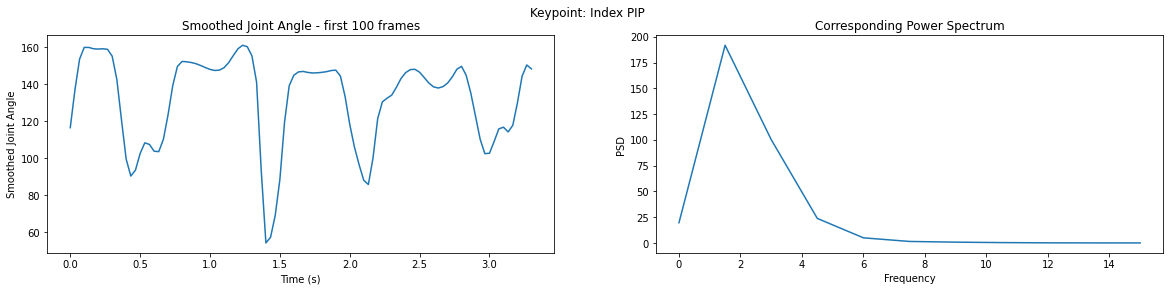

PSD Max coefficient values: [ 23.743309 100.205414 191.74391 ], Corresponding Frequencies: [4.5 3.  1.5]


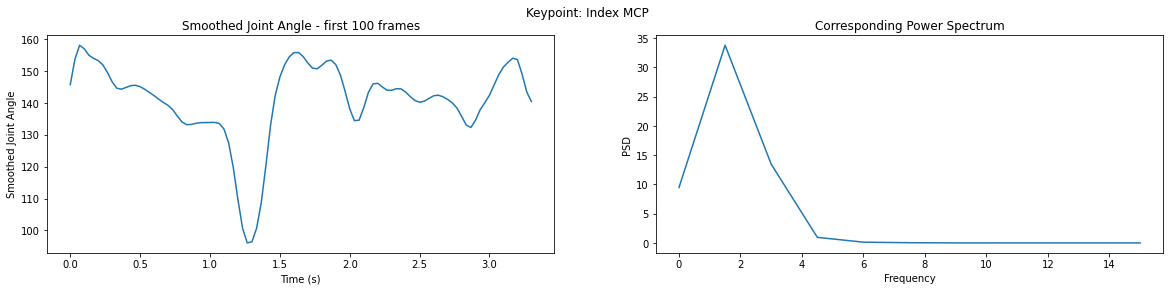

PSD Max coefficient values: [ 9.469046 13.451362 33.78404 ], Corresponding Frequencies: [0.  3.  1.5]


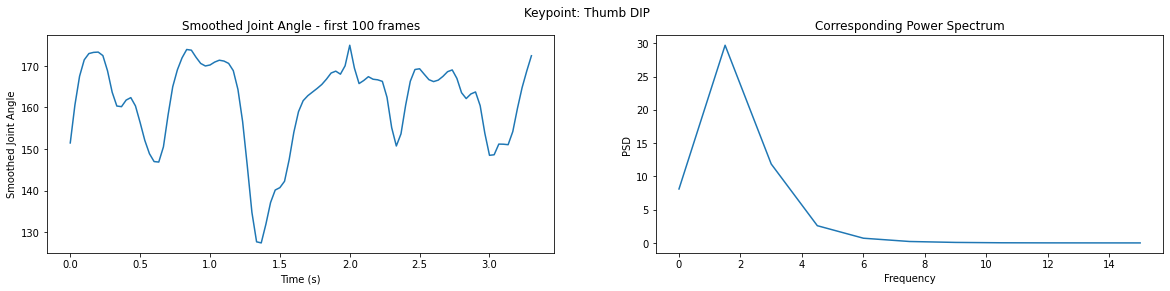

PSD Max coefficient values: [ 8.10809  11.863773 29.70912 ], Corresponding Frequencies: [0.  3.  1.5]


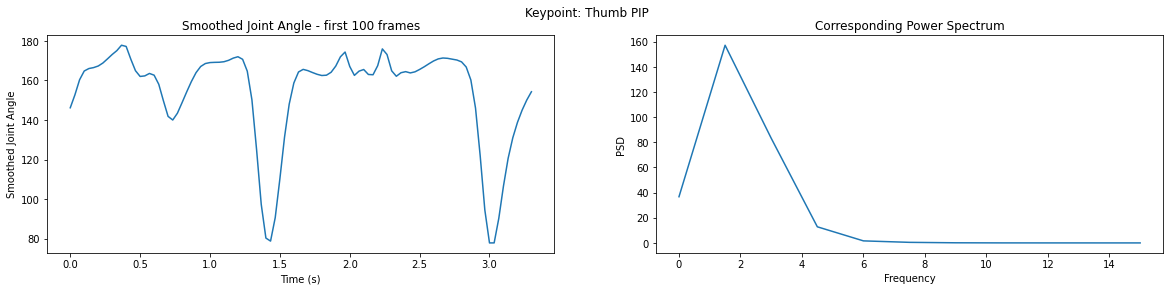

PSD Max coefficient values: [ 36.737778  83.22952  157.20197 ], Corresponding Frequencies: [0.  3.  1.5]


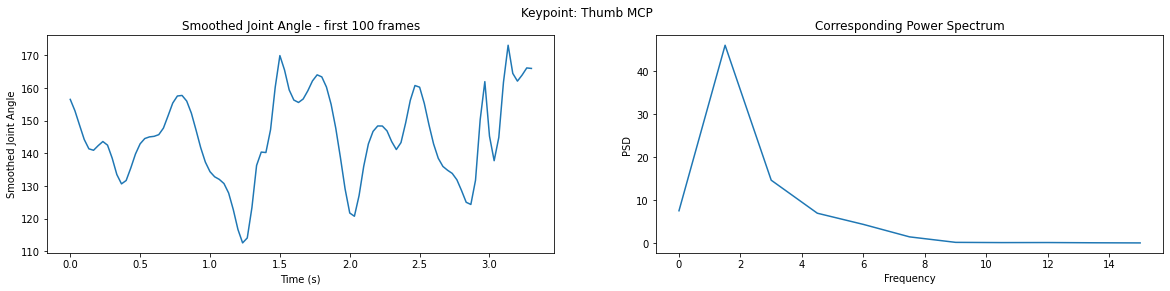

PSD Max coefficient values: [ 7.4961557 14.612538  46.049698 ], Corresponding Frequencies: [0.  3.  1.5]


In [ ]:
plot_signal_and_psd(joints = True, smoothed = True, centered = False)

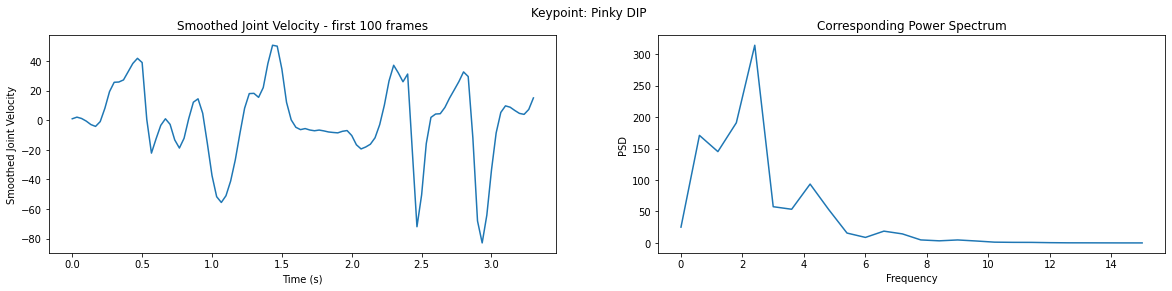

PSD Max coefficient values: [170.98824 190.98499 314.25412], Corresponding Frequencies: [0.6 1.8 2.4]


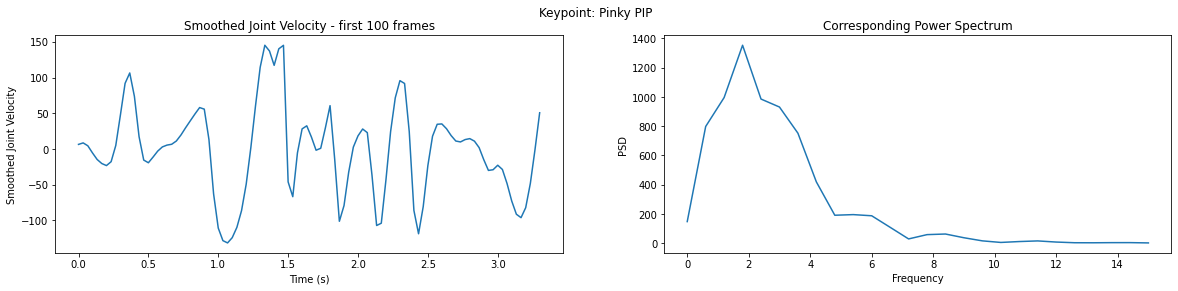

PSD Max coefficient values: [ 985.70844  996.03107 1353.7968 ], Corresponding Frequencies: [2.4 1.2 1.8]


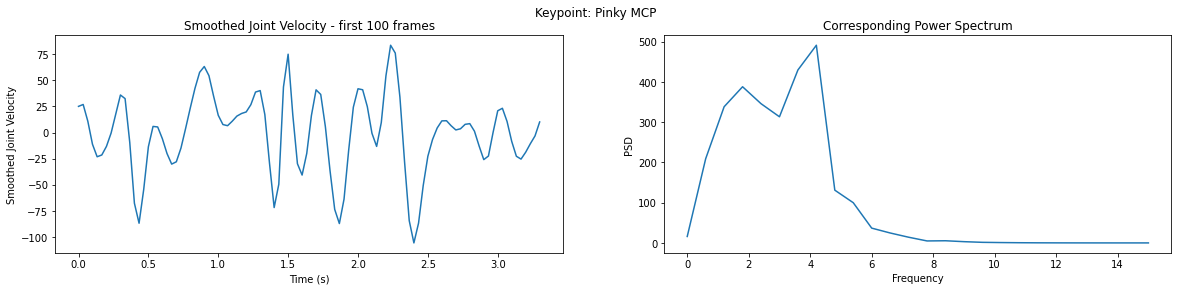

PSD Max coefficient values: [388.0817  429.79465 491.23483], Corresponding Frequencies: [1.8 3.6 4.2]


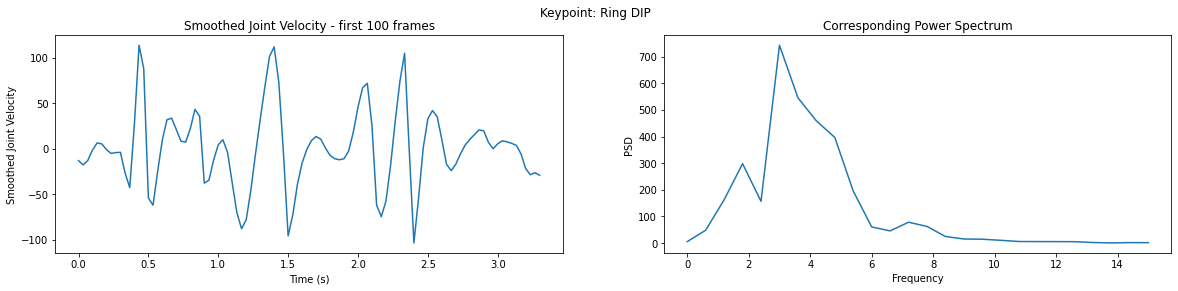

PSD Max coefficient values: [458.59268 545.46234 742.4009 ], Corresponding Frequencies: [4.2 3.6 3. ]


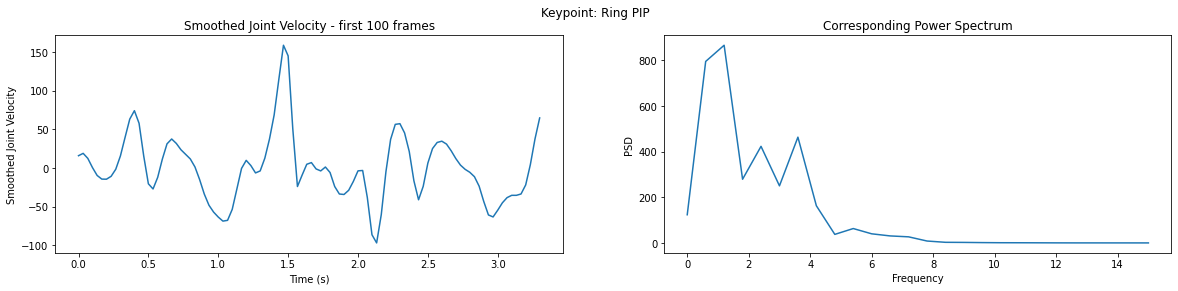

PSD Max coefficient values: [463.58972 866.45074 795.48834], Corresponding Frequencies: [3.6 1.2 0.6]


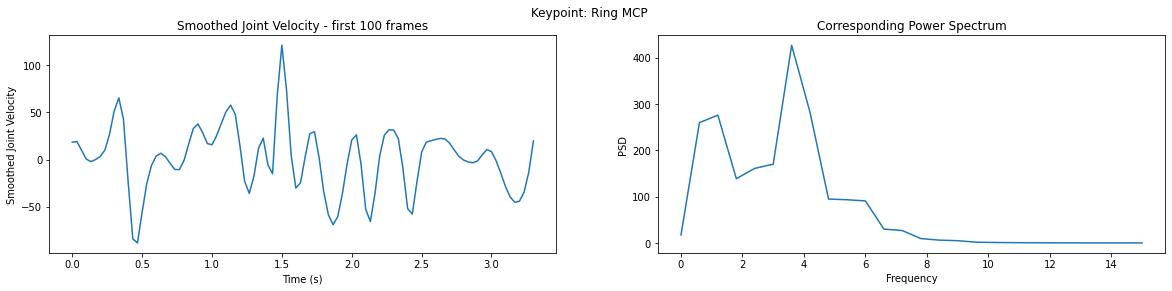

PSD Max coefficient values: [276.17868 281.30862 427.243  ], Corresponding Frequencies: [1.2 4.2 3.6]


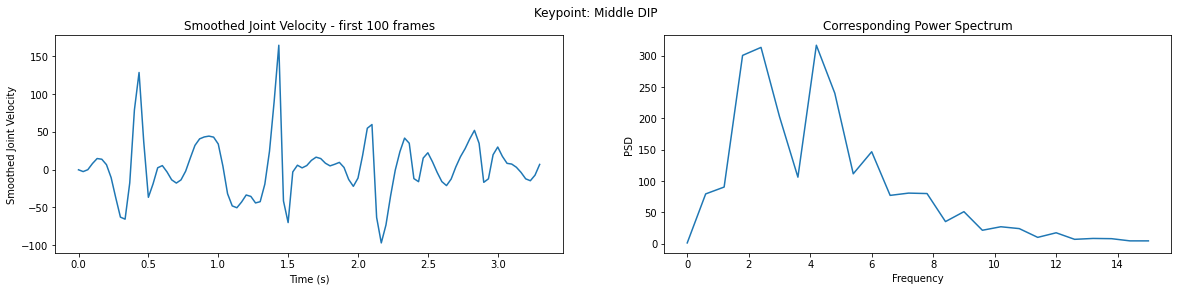

PSD Max coefficient values: [300.58224 313.3596  316.8044 ], Corresponding Frequencies: [1.8 2.4 4.2]


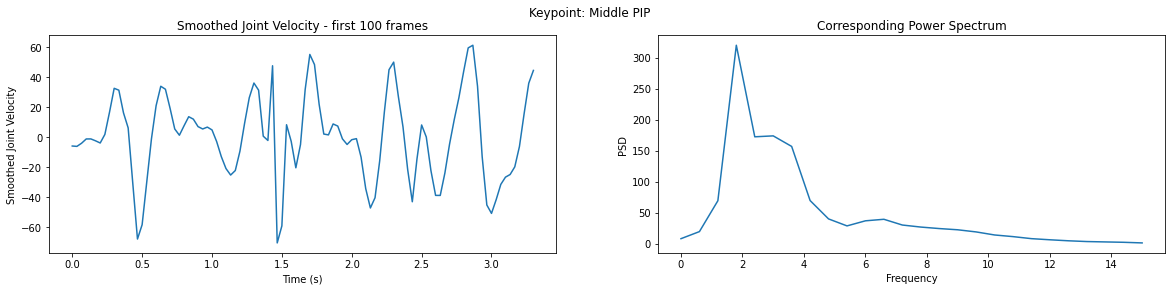

PSD Max coefficient values: [172.14522 173.64882 319.85617], Corresponding Frequencies: [2.4 3.  1.8]


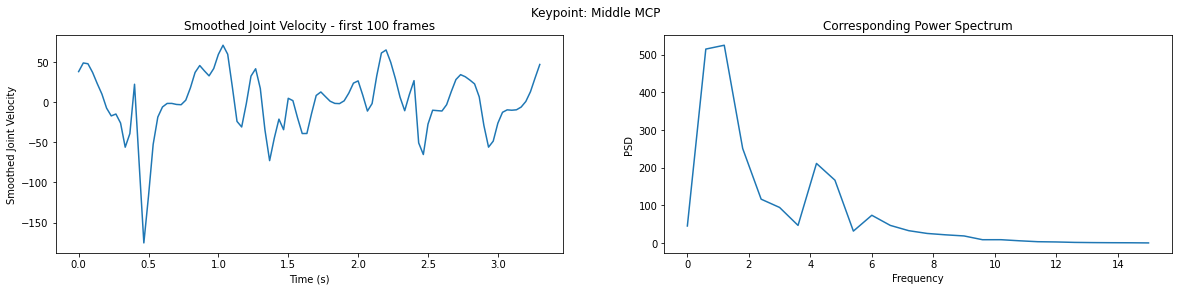

PSD Max coefficient values: [250.9854  515.09216 525.2714 ], Corresponding Frequencies: [1.8 0.6 1.2]


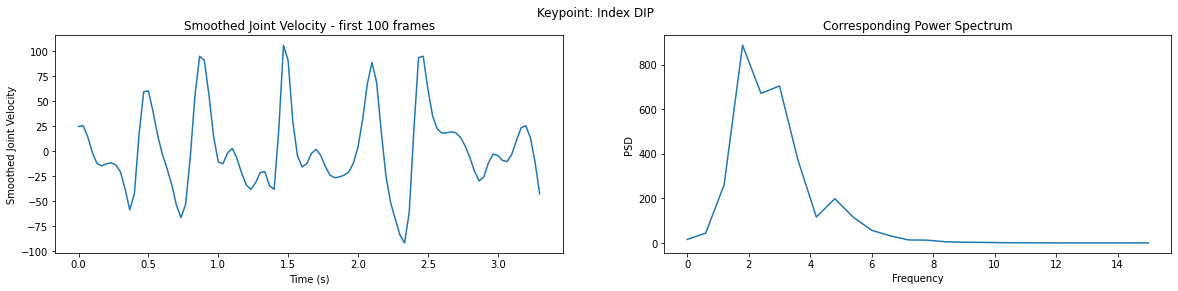

PSD Max coefficient values: [670.71985 886.87897 704.3216 ], Corresponding Frequencies: [2.4 1.8 3. ]


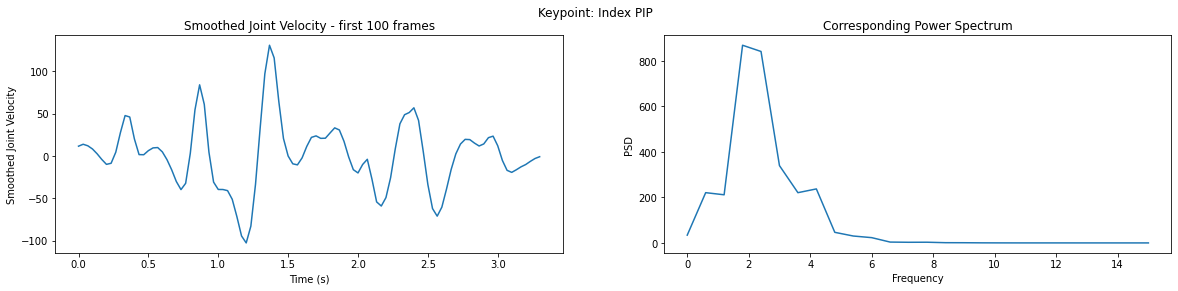

PSD Max coefficient values: [339.8312  841.5667  868.96747], Corresponding Frequencies: [3.  2.4 1.8]


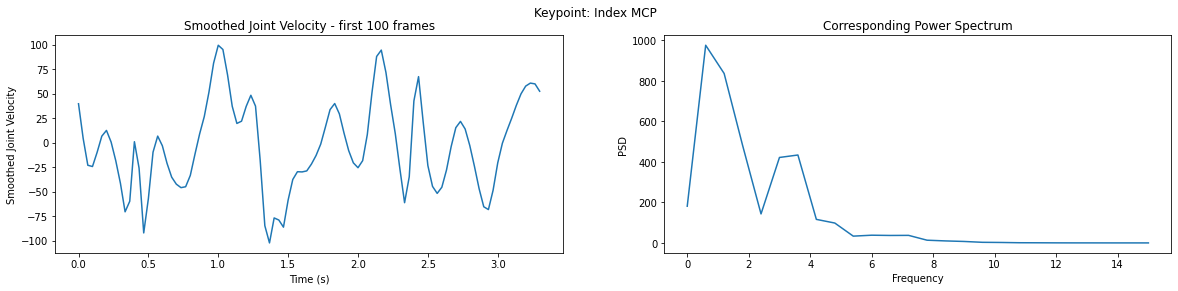

PSD Max coefficient values: [482.04147 836.7513  976.0992 ], Corresponding Frequencies: [1.8 1.2 0.6]


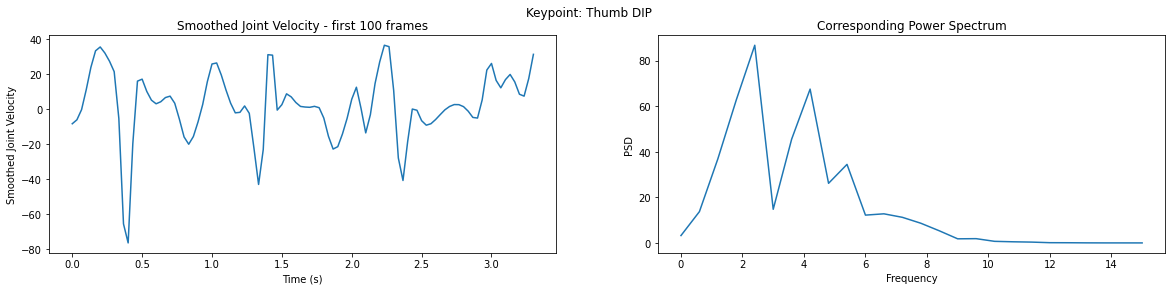

PSD Max coefficient values: [62.872086 67.57406  86.84784 ], Corresponding Frequencies: [1.8 4.2 2.4]


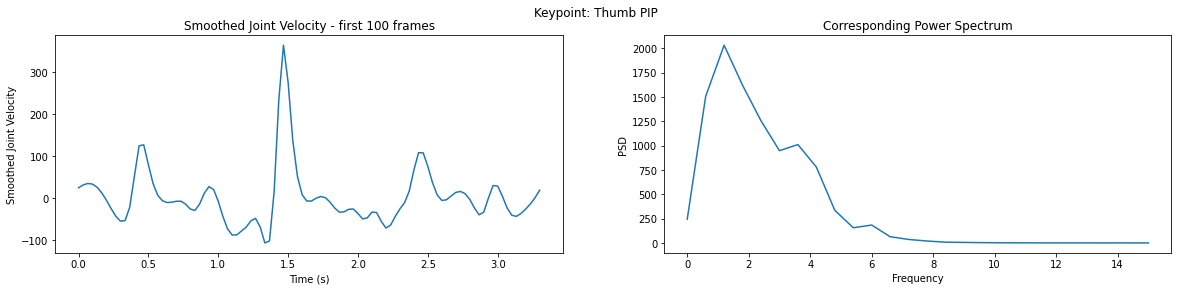

PSD Max coefficient values: [1506.2563 1619.8159 2031.124 ], Corresponding Frequencies: [0.6 1.8 1.2]


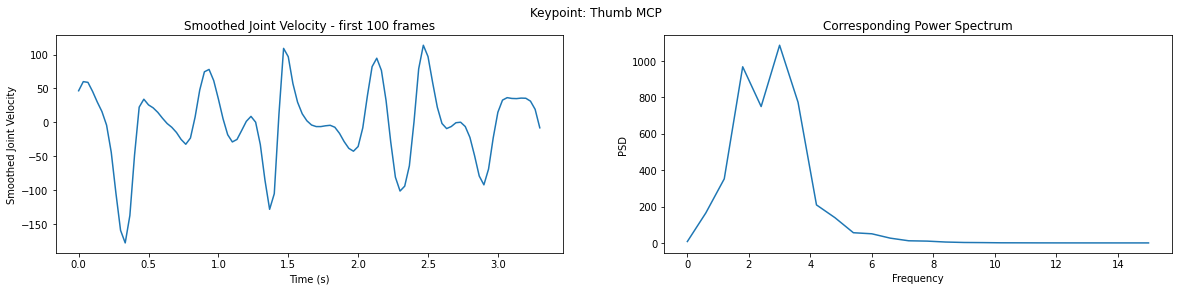

PSD Max coefficient values: [ 772.5449   967.54156 1085.8087 ], Corresponding Frequencies: [3.6 1.8 3. ]


In [ ]:
plot_signal_and_psd(joints = True, smoothed = True, centered = False, velocity = True, nperseg = 50)

In [75]:
plot_signal_and_psd(neural = True, nperseg = 50)

Output hidden; open in https://colab.research.google.com to view.

Epoch: 000, LR: 0.010000, Train Loss: 4284.9228516
Epoch: 050, LR: 0.010000, Train Loss: 137.2061310
Epoch: 100, LR: 0.010000, Train Loss: 112.8528442
Epoch: 150, LR: 0.010000, Train Loss: 106.8962936
Epoch: 200, LR: 0.010000, Train Loss: 103.0575867
Epoch: 250, LR: 0.010000, Train Loss: 100.3369217
Epoch: 300, LR: 0.010000, Train Loss: 98.4073334


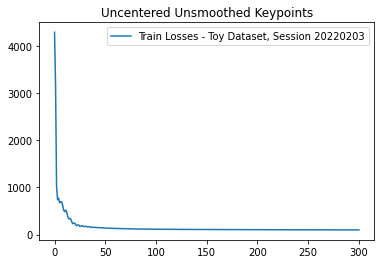

Epoch: 000, LR: 0.010000, Train Loss: 6327.9418945
Epoch: 050, LR: 0.010000, Train Loss: 101.9010849
Epoch: 100, LR: 0.010000, Train Loss: 80.2326279
Epoch: 150, LR: 0.010000, Train Loss: 79.4523697
Epoch: 200, LR: 0.010000, Train Loss: 80.8735428
Epoch: 250, LR: 0.010000, Train Loss: 78.7974091
Epoch: 300, LR: 0.010000, Train Loss: 79.4350357


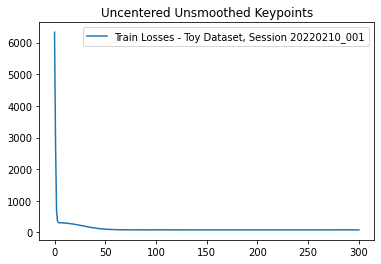

Epoch: 000, LR: 0.010000, Train Loss: 8502.4687500
Epoch: 050, LR: 0.010000, Train Loss: 113.9392242
Epoch: 100, LR: 0.010000, Train Loss: 95.0429840
Epoch: 150, LR: 0.010000, Train Loss: 94.8566132
Epoch: 200, LR: 0.010000, Train Loss: 94.6425781
Epoch: 250, LR: 0.010000, Train Loss: 94.4583359
Epoch: 300, LR: 0.010000, Train Loss: 96.7436676


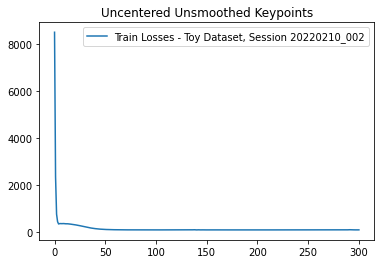

Epoch: 000, LR: 0.010000, Train Loss: 7014.3608398
Epoch: 050, LR: 0.010000, Train Loss: 372.5520935
Epoch: 100, LR: 0.010000, Train Loss: 362.4531860
Epoch: 150, LR: 0.010000, Train Loss: 352.2773743
Epoch: 200, LR: 0.010000, Train Loss: 342.2652893
Epoch: 250, LR: 0.010000, Train Loss: 332.5150757
Epoch: 300, LR: 0.010000, Train Loss: 323.0733948


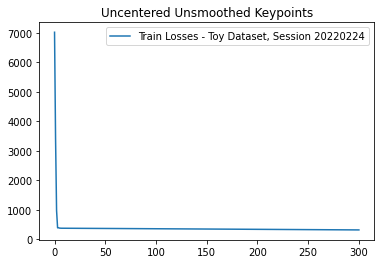

Epoch: 000, LR: 0.010000, Train Loss: 890.0588989
Epoch: 050, LR: 0.010000, Train Loss: 85.6795807
Epoch: 100, LR: 0.010000, Train Loss: 75.5198135
Epoch: 150, LR: 0.010000, Train Loss: 69.1945496
Epoch: 200, LR: 0.010000, Train Loss: 65.0217743
Epoch: 250, LR: 0.010000, Train Loss: 60.8800697
Epoch: 300, LR: 0.010000, Train Loss: 57.8634338


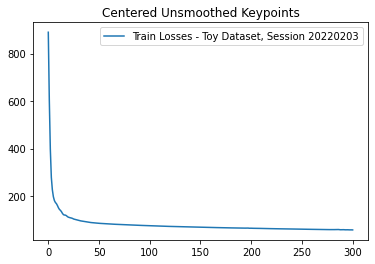

Epoch: 000, LR: 0.010000, Train Loss: 332.2191162
Epoch: 050, LR: 0.010000, Train Loss: 48.0924454
Epoch: 100, LR: 0.010000, Train Loss: 38.4395027
Epoch: 150, LR: 0.010000, Train Loss: 33.8805351
Epoch: 200, LR: 0.010000, Train Loss: 30.7357883
Epoch: 250, LR: 0.010000, Train Loss: 28.5911846
Epoch: 300, LR: 0.010000, Train Loss: 27.0968094


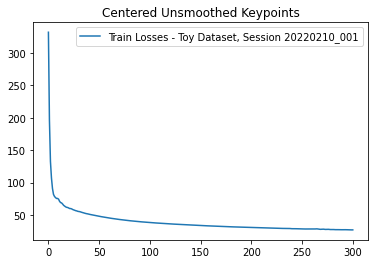

Epoch: 000, LR: 0.010000, Train Loss: 436.5248108
Epoch: 050, LR: 0.010000, Train Loss: 60.4769287
Epoch: 100, LR: 0.010000, Train Loss: 51.0971909
Epoch: 150, LR: 0.010000, Train Loss: 46.0829773
Epoch: 200, LR: 0.010000, Train Loss: 41.9973564
Epoch: 250, LR: 0.010000, Train Loss: 39.3891754
Epoch: 300, LR: 0.010000, Train Loss: 37.3925209


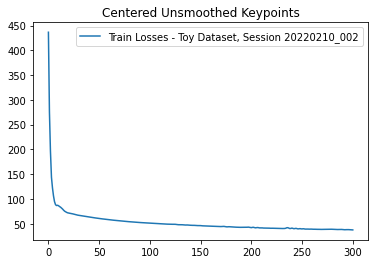

Epoch: 000, LR: 0.010000, Train Loss: 423.1207275
Epoch: 050, LR: 0.010000, Train Loss: 67.9108353
Epoch: 100, LR: 0.010000, Train Loss: 56.2368164
Epoch: 150, LR: 0.010000, Train Loss: 49.0213547
Epoch: 200, LR: 0.010000, Train Loss: 44.3438873
Epoch: 250, LR: 0.010000, Train Loss: 40.9535065
Epoch: 300, LR: 0.010000, Train Loss: 40.1375389


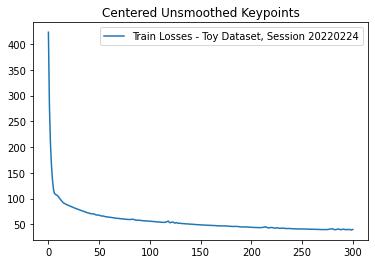

Epoch: 000, LR: 0.010000, Train Loss: 812.8535156
Epoch: 050, LR: 0.010000, Train Loss: 82.9171677
Epoch: 100, LR: 0.010000, Train Loss: 73.1914825
Epoch: 150, LR: 0.010000, Train Loss: 66.7991562
Epoch: 200, LR: 0.010000, Train Loss: 61.1448288
Epoch: 250, LR: 0.010000, Train Loss: 56.6534920
Epoch: 300, LR: 0.010000, Train Loss: 52.6535606


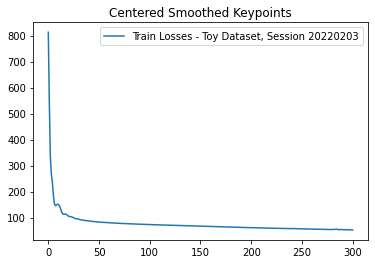

Epoch: 000, LR: 0.010000, Train Loss: 346.7451172
Epoch: 050, LR: 0.010000, Train Loss: 48.0792809
Epoch: 100, LR: 0.010000, Train Loss: 35.9183121
Epoch: 150, LR: 0.010000, Train Loss: 28.7075119
Epoch: 200, LR: 0.010000, Train Loss: 25.0194225
Epoch: 250, LR: 0.010000, Train Loss: 22.8752880
Epoch: 300, LR: 0.010000, Train Loss: 21.2263489


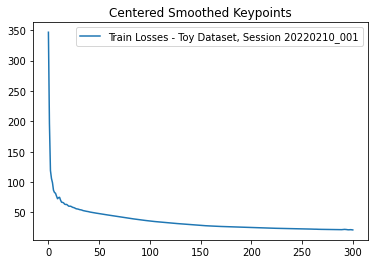

Epoch: 000, LR: 0.010000, Train Loss: 441.4049072
Epoch: 050, LR: 0.010000, Train Loss: 58.7436104
Epoch: 100, LR: 0.010000, Train Loss: 51.5866470
Epoch: 150, LR: 0.010000, Train Loss: 46.2289581
Epoch: 200, LR: 0.010000, Train Loss: 41.8110962
Epoch: 250, LR: 0.010000, Train Loss: 38.7309990
Epoch: 300, LR: 0.010000, Train Loss: 38.7816658


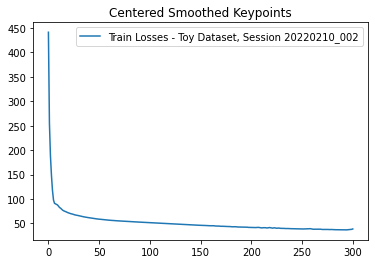

Epoch: 000, LR: 0.010000, Train Loss: 472.8250427
Epoch: 050, LR: 0.010000, Train Loss: 67.3752747
Epoch: 100, LR: 0.010000, Train Loss: 54.0667648
Epoch: 150, LR: 0.010000, Train Loss: 47.6339188
Epoch: 200, LR: 0.010000, Train Loss: 42.8792000
Epoch: 250, LR: 0.010000, Train Loss: 38.2024002
Epoch: 300, LR: 0.010000, Train Loss: 34.8703232


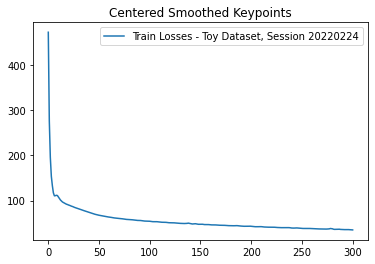

Epoch: 000, LR: 0.010000, Train Loss: 1659.3929443
Epoch: 050, LR: 0.010000, Train Loss: 167.7388153
Epoch: 100, LR: 0.010000, Train Loss: 152.5080566
Epoch: 150, LR: 0.010000, Train Loss: 139.0183563
Epoch: 200, LR: 0.010000, Train Loss: 127.1933975
Epoch: 250, LR: 0.010000, Train Loss: 117.4008789
Epoch: 300, LR: 0.010000, Train Loss: 110.2041473


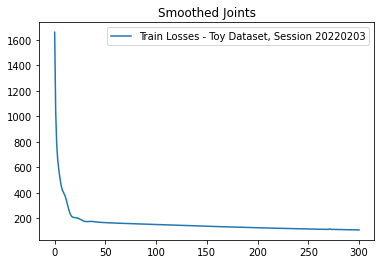

Epoch: 000, LR: 0.010000, Train Loss: 2111.2377930
Epoch: 050, LR: 0.010000, Train Loss: 85.0271149
Epoch: 100, LR: 0.010000, Train Loss: 77.0001678
Epoch: 150, LR: 0.010000, Train Loss: 67.2844162
Epoch: 200, LR: 0.010000, Train Loss: 61.3179741
Epoch: 250, LR: 0.010000, Train Loss: 58.4440460
Epoch: 300, LR: 0.010000, Train Loss: 56.7098045


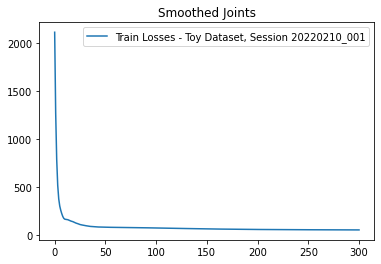

Epoch: 000, LR: 0.010000, Train Loss: 1452.3804932
Epoch: 050, LR: 0.010000, Train Loss: 107.8727798
Epoch: 100, LR: 0.010000, Train Loss: 103.0692215
Epoch: 150, LR: 0.010000, Train Loss: 97.9041519
Epoch: 200, LR: 0.010000, Train Loss: 89.3193512
Epoch: 250, LR: 0.010000, Train Loss: 83.4874954
Epoch: 300, LR: 0.010000, Train Loss: 80.2585449


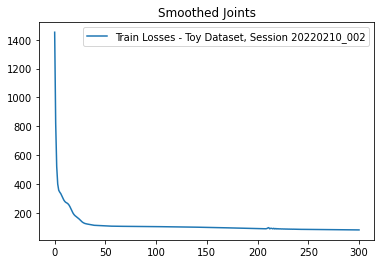

Epoch: 000, LR: 0.010000, Train Loss: 2221.2343750
Epoch: 050, LR: 0.010000, Train Loss: 105.9424973
Epoch: 100, LR: 0.010000, Train Loss: 99.8411789
Epoch: 150, LR: 0.010000, Train Loss: 97.1109695
Epoch: 200, LR: 0.010000, Train Loss: 93.7239685
Epoch: 250, LR: 0.010000, Train Loss: 90.4872360
Epoch: 300, LR: 0.010000, Train Loss: 88.0389557


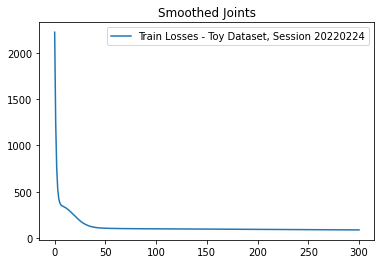

Epoch: 000, LR: 0.010000, Train Loss: 998.0333252
Epoch: 050, LR: 0.010000, Train Loss: 220.7689667
Epoch: 100, LR: 0.010000, Train Loss: 177.2349548
Epoch: 150, LR: 0.010000, Train Loss: 163.1168671
Epoch: 200, LR: 0.010000, Train Loss: 154.6772461
Epoch: 250, LR: 0.010000, Train Loss: 148.6820679
Epoch: 300, LR: 0.010000, Train Loss: 142.9927063


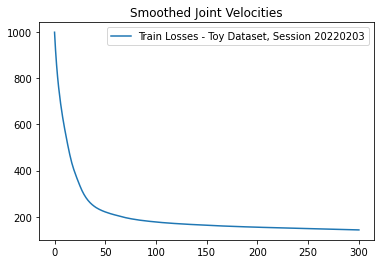

Epoch: 000, LR: 0.010000, Train Loss: 808.6766357
Epoch: 050, LR: 0.010000, Train Loss: 101.2124786
Epoch: 100, LR: 0.010000, Train Loss: 85.0923920
Epoch: 150, LR: 0.010000, Train Loss: 77.3998718
Epoch: 200, LR: 0.010000, Train Loss: 71.7092209
Epoch: 250, LR: 0.010000, Train Loss: 66.8851624
Epoch: 300, LR: 0.010000, Train Loss: 62.2998047


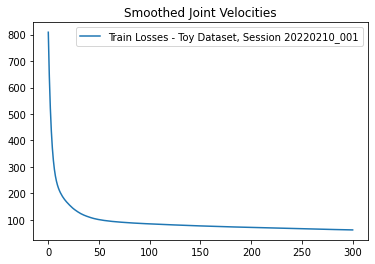

Epoch: 000, LR: 0.010000, Train Loss: 394.6714783
Epoch: 050, LR: 0.010000, Train Loss: 113.7394485
Epoch: 100, LR: 0.010000, Train Loss: 93.0057373
Epoch: 150, LR: 0.010000, Train Loss: 83.8572769
Epoch: 200, LR: 0.010000, Train Loss: 78.8697357
Epoch: 250, LR: 0.010000, Train Loss: 75.5395966
Epoch: 300, LR: 0.010000, Train Loss: 72.9466248


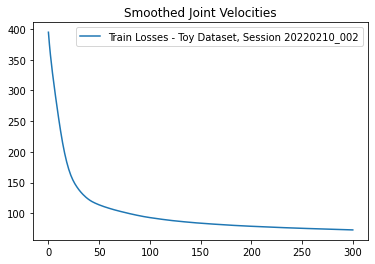

Epoch: 000, LR: 0.010000, Train Loss: 1058.5336914
Epoch: 050, LR: 0.010000, Train Loss: 135.8895569
Epoch: 100, LR: 0.010000, Train Loss: 111.2852097
Epoch: 150, LR: 0.010000, Train Loss: 103.9382553
Epoch: 200, LR: 0.010000, Train Loss: 99.9530563
Epoch: 250, LR: 0.010000, Train Loss: 96.3772354
Epoch: 300, LR: 0.010000, Train Loss: 92.9288635


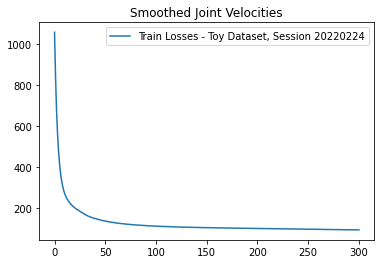

In [54]:
toy_list_names = ['Uncentered Unsmoothed Keypoints', 'Centered Unsmoothed Keypoints', 'Centered Smoothed Keypoints', 'Smoothed Joints', 'Smoothed Joint Velocities']
toy_list = [toy_loader_uncentered_unsmoothed_list,toy_loader_unsmoothed_list,toy_loader_list,toy_joints_loader_list,toy_joint_velocities_loader_list,]

for name, lst in zip(toy_list_names, toy_list):
    for i in range(len(lst)):
        if (name == 'Smoothed Joints') or (name == 'Smoothed Joint Velocities'):
            model = TempConvNet(input_dim = 15, output_dim=dataset_list[i].num_neural_units, num_conv_layers = 1,\
                    num_readout_layers = 1, kernel_size = 1, filters_per_conv = 1, causal = False).to(device)
        else:
            model = TempConvNet(input_dim = 69, output_dim=dataset_list[i].num_neural_units, num_conv_layers = 1,\
                    num_readout_layers = 1, kernel_size = 1, filters_per_conv = 1, causal = False).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   

        train_losses = []

        for epoch in range(301):
            # torch.cuda.empty_cache()
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train(lst[i], model, optimizer, criterion)
            if epoch % 50 ==0:
                print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}'\
                      .format(epoch, lr, train_loss))

            train_losses.append(train_loss)

        instance_data = get_instance_losses(lst[i], model)
        target = pred = instance_data[2]
        pred = instance_data[3]

        plt.plot(train_losses)
        plt.title(name)
        plt.legend(['Train Losses - Toy Dataset, Session {}'.format(dataset_list[i].date)])
        plt.show()

        # nrows, ncols = hist_shapes_list[i]
        # xaxis = np.arange(100)*0.033333
        # fig, ax = plt.subplots(nrows = nrows, ncols = ncols)
        # fig.set_size_inches(30, 50)
        # fig.tight_layout(pad=3.0)
        # for l in range(nrows*ncols):
        #     j = math.floor(l/ncols)
        #     k = l%ncols
        #     if (i != 3) and (l ==(nrows*ncols -1)):
        #         ax[j][k].plot(np.zeros(dim_vals1.shape[0]))
        #     else:
        #         dim_vals1 = target[:,l]
        #         dim_vals2 = pred[:,l]
        #         ax[j][k].plot(xaxis, dim_vals1, label='Target')
        #         ax[j][k].plot(xaxis, dim_vals2, label='Prediction')
        #         ax[j][k].legend()
        #     ax[j][k].set_title('Electrode {}'.format(l))
        #     ax[j][k].set_xlabel('Time (s)')
        #     ax[j][k].set_ylabel('Firing Rate')
        # plt.show()

Epoch: 000, LR: 0.010000, Train Loss: 427.4852905
Epoch: 050, LR: 0.010000, Train Loss: 61.9408722
Epoch: 100, LR: 0.010000, Train Loss: 47.2436638
Epoch: 150, LR: 0.010000, Train Loss: 39.5359192
Epoch: 200, LR: 0.010000, Train Loss: 35.7292900
Epoch: 250, LR: 0.010000, Train Loss: 33.6233139
Epoch: 300, LR: 0.010000, Train Loss: 31.8967514


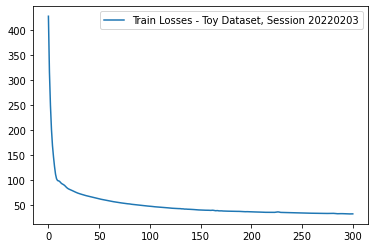

Epoch: 000, LR: 0.010000, Train Loss: 443.7001648
Epoch: 050, LR: 0.010000, Train Loss: 76.0889053
Epoch: 100, LR: 0.010000, Train Loss: 63.4183426
Epoch: 150, LR: 0.010000, Train Loss: 53.9972572
Epoch: 200, LR: 0.010000, Train Loss: 45.8041840
Epoch: 250, LR: 0.010000, Train Loss: 42.2488899
Epoch: 300, LR: 0.010000, Train Loss: 36.3125267


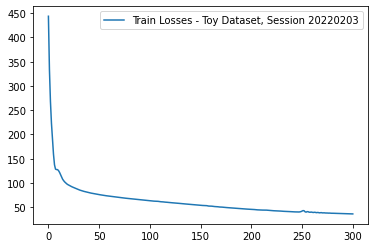

Epoch: 000, LR: 0.010000, Train Loss: 334.2842407
Epoch: 050, LR: 0.010000, Train Loss: 57.8191223
Epoch: 100, LR: 0.010000, Train Loss: 49.7713928
Epoch: 150, LR: 0.010000, Train Loss: 43.1380310
Epoch: 200, LR: 0.010000, Train Loss: 38.4355507
Epoch: 250, LR: 0.010000, Train Loss: 35.4546509
Epoch: 300, LR: 0.010000, Train Loss: 32.9638596


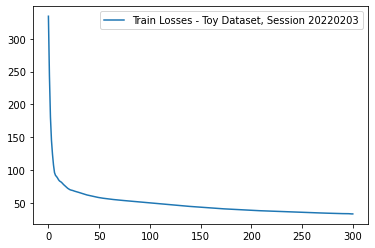

Epoch: 000, LR: 0.010000, Train Loss: 473.4626770
Epoch: 050, LR: 0.010000, Train Loss: 84.1896820
Epoch: 100, LR: 0.010000, Train Loss: 68.3878250
Epoch: 150, LR: 0.010000, Train Loss: 59.6472702
Epoch: 200, LR: 0.010000, Train Loss: 55.7843170
Epoch: 250, LR: 0.010000, Train Loss: 52.8043709
Epoch: 300, LR: 0.010000, Train Loss: 50.0097351


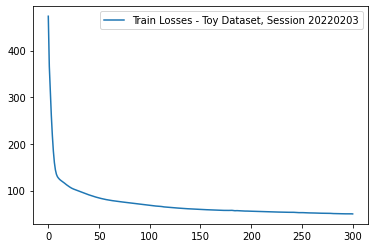

Epoch: 000, LR: 0.010000, Train Loss: 1863.1959229
Epoch: 050, LR: 0.010000, Train Loss: 174.4978638
Epoch: 100, LR: 0.010000, Train Loss: 141.8651733
Epoch: 150, LR: 0.010000, Train Loss: 114.2833633
Epoch: 200, LR: 0.010000, Train Loss: 98.2722931
Epoch: 250, LR: 0.010000, Train Loss: 87.8439941
Epoch: 300, LR: 0.010000, Train Loss: 79.7193375


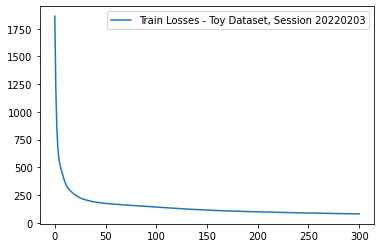

Epoch: 000, LR: 0.010000, Train Loss: 1837.8162842
Epoch: 050, LR: 0.010000, Train Loss: 216.4926605
Epoch: 100, LR: 0.010000, Train Loss: 174.3112488
Epoch: 150, LR: 0.010000, Train Loss: 140.3531647
Epoch: 200, LR: 0.010000, Train Loss: 122.2313538
Epoch: 250, LR: 0.010000, Train Loss: 111.5984192
Epoch: 300, LR: 0.010000, Train Loss: 104.3942719


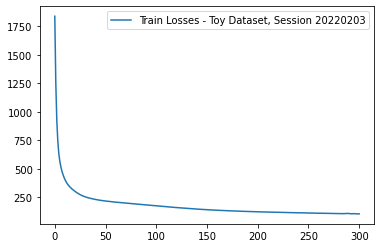

Epoch: 000, LR: 0.010000, Train Loss: 466.7438660
Epoch: 050, LR: 0.010000, Train Loss: 95.5703812
Epoch: 100, LR: 0.010000, Train Loss: 76.4219589
Epoch: 150, LR: 0.010000, Train Loss: 62.8010178
Epoch: 200, LR: 0.010000, Train Loss: 53.2965508
Epoch: 250, LR: 0.010000, Train Loss: 47.2997513
Epoch: 300, LR: 0.010000, Train Loss: 44.8385429


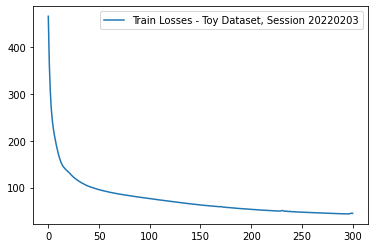

Epoch: 000, LR: 0.010000, Train Loss: 696.9143066
Epoch: 050, LR: 0.010000, Train Loss: 106.8859863
Epoch: 100, LR: 0.010000, Train Loss: 89.4801865
Epoch: 150, LR: 0.010000, Train Loss: 76.7649918
Epoch: 200, LR: 0.010000, Train Loss: 67.3638229
Epoch: 250, LR: 0.010000, Train Loss: 61.5051804
Epoch: 300, LR: 0.010000, Train Loss: 58.0193176


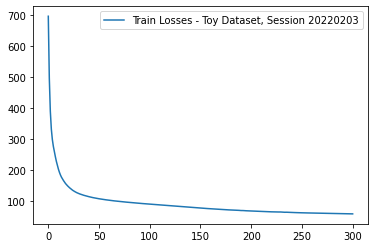

In [46]:
for i, toy_loader in enumerate(toy_loader_mlp_list):
    if i > 3:
        model = FCNet(input_dim = 15, output_dim=dataset_list[i-4].num_neural_units, num_layers = 2, hidden_layer_dim = 35).to(device)
    else:
        model = FCNet(input_dim = 69, output_dim=dataset_list[i].num_neural_units, num_layers = 2, hidden_layer_dim = 35).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   

    train_losses = []

    for epoch in range(301):
        # torch.cuda.empty_cache()
        lr = scheduler.optimizer.param_groups[0]['lr']
        train_loss = train(toy_loader, model, optimizer, criterion)
        if epoch % 50 ==0:
            print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}'\
                  .format(epoch, lr, train_loss))

        train_losses.append(train_loss)

    plt.plot(train_losses)
    plt.legend(['Train Losses - Toy Dataset, Session 20220203'])
    plt.show()

In [ ]:
def get_pr2(real_data, predictions, EPS = 0.000001):
    predictions = predictions+EPS
    m = np.mean(real_data, axis = 0)
    division1 = (real_data/predictions)+EPS
    division2 = (real_data/m)+EPS
    sum1 = np.sum(real_data*np.log( division1 ) - ( real_data - predictions ) )
    sum2 = np.sum( real_data*np.log( division2 ) - ( real_data - m ) )
    if ( sum2 == 0 ):
      sum2 = EPS
    pR2 = 1 - sum1/sum2
    return(pR2)

Date: 20220203
Epoch: 000, LR: 0.010000, Train Loss: 225.7067921, Test Loss: 173.4743458
Epoch: 050, LR: 0.000824, Train Loss: 129.8752569, Test Loss: 140.0579596
Epoch: 100, LR: 0.000138, Train Loss: 126.1014140, Test Loss: 137.1831907
Epoch: 150, LR: 0.000023, Train Loss: 125.3737730, Test Loss: 136.8629378
Epoch: 200, LR: 0.000010, Train Loss: 125.2708114, Test Loss: 136.8463470
Epoch: 250, LR: 0.000010, Train Loss: 125.2281625, Test Loss: 136.8603397
Epoch: 300, LR: 0.000010, Train Loss: 125.1860394, Test Loss: 136.8840202
Epoch: 350, LR: 0.000010, Train Loss: 125.1446741, Test Loss: 136.8987666
Epoch: 400, LR: 0.000010, Train Loss: 125.1035175, Test Loss: 136.9026592
Epoch: 450, LR: 0.000010, Train Loss: 125.0626131, Test Loss: 136.9147456
Time to train model: 82.48284220695496


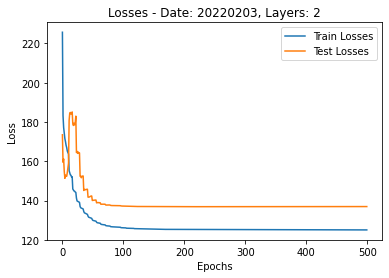

(14400, 44) (14400, 44)
R2 Train: 0.2611353531787576, R2 Test: 0.16747715982814038
Date: 20220210_001
Epoch: 000, LR: 0.010000, Train Loss: 163.5308041, Test Loss: 131.5843982
Epoch: 050, LR: 0.003430, Train Loss: 115.3183664, Test Loss: 114.5188290
Epoch: 100, LR: 0.001681, Train Loss: 111.3117730, Test Loss: 112.6895675
Epoch: 150, LR: 0.000576, Train Loss: 108.7427601, Test Loss: 111.3778177
Epoch: 200, LR: 0.000404, Train Loss: 107.8269279, Test Loss: 110.8277514
Epoch: 250, LR: 0.000047, Train Loss: 107.0499214, Test Loss: 110.7628418
Epoch: 300, LR: 0.000010, Train Loss: 106.9615301, Test Loss: 110.7613015
Epoch: 350, LR: 0.000010, Train Loss: 106.9501847, Test Loss: 110.7600846
Epoch: 400, LR: 0.000010, Train Loss: 106.9389724, Test Loss: 110.7614472
Epoch: 450, LR: 0.000010, Train Loss: 106.9279091, Test Loss: 110.7656680
Time to train model: 79.91302275657654


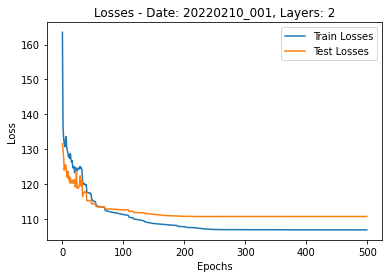

(14400, 62) (14400, 62)
R2 Train: 0.18464030397820336, R2 Test: 0.10603200540080325
Date: 20220210_002
Epoch: 000, LR: 0.010000, Train Loss: 169.3524688, Test Loss: 243.4255286
Epoch: 050, LR: 0.004900, Train Loss: 121.1855664, Test Loss: 123.4262255
Epoch: 100, LR: 0.002401, Train Loss: 115.9632453, Test Loss: 119.3931118
Epoch: 150, LR: 0.001176, Train Loss: 113.2299700, Test Loss: 116.4005894
Epoch: 200, LR: 0.000097, Train Loss: 110.5998043, Test Loss: 116.6177520
Epoch: 250, LR: 0.000010, Train Loss: 110.3628179, Test Loss: 116.5064207
Epoch: 300, LR: 0.000010, Train Loss: 110.3503368, Test Loss: 116.5194238
Epoch: 350, LR: 0.000010, Train Loss: 110.3380982, Test Loss: 116.5417087
Epoch: 400, LR: 0.000010, Train Loss: 110.3263387, Test Loss: 116.5599803
Epoch: 450, LR: 0.000010, Train Loss: 110.3148175, Test Loss: 116.5760411
Time to train model: 80.01135587692261


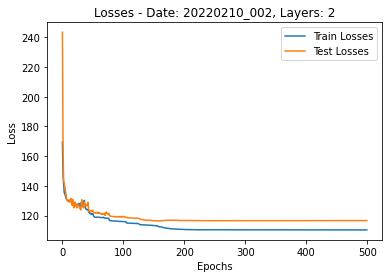

(14400, 62) (14400, 62)
R2 Train: 0.23400950901199782, R2 Test: 0.15885157178247922
Date: 20220224
Epoch: 000, LR: 0.010000, Train Loss: 134.9784344, Test Loss: 127.7760605
Epoch: 050, LR: 0.002401, Train Loss: 107.6576773, Test Loss: 112.4826482
Epoch: 100, LR: 0.000576, Train Loss: 105.1589176, Test Loss: 110.6131596
Epoch: 150, LR: 0.000033, Train Loss: 104.5165380, Test Loss: 110.9040663
Epoch: 200, LR: 0.000010, Train Loss: 104.4831703, Test Loss: 110.9208696
Epoch: 250, LR: 0.000010, Train Loss: 104.4766884, Test Loss: 110.9302695
Epoch: 300, LR: 0.000010, Train Loss: 104.4703156, Test Loss: 110.9370291
Epoch: 350, LR: 0.000010, Train Loss: 104.4640492, Test Loss: 110.9444790
Epoch: 400, LR: 0.000010, Train Loss: 104.4578444, Test Loss: 110.9512062
Epoch: 450, LR: 0.000010, Train Loss: 104.4517655, Test Loss: 110.9551430
Time to train model: 90.86274552345276


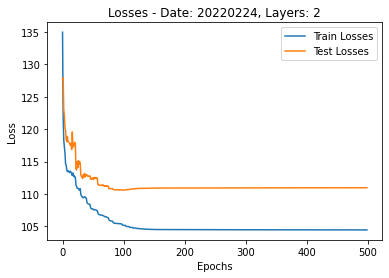

(14400, 108) (14400, 108)
R2 Train: 0.05132583445411352, R2 Test: -0.0014649716982560082
Date: 20220203
Epoch: 000, LR: 0.010000, Train Loss: 325.0224874, Test Loss: 241.7579098
Epoch: 050, LR: 0.003430, Train Loss: 158.9782325, Test Loss: 162.9918764
Epoch: 100, LR: 0.000282, Train Loss: 150.5529189, Test Loss: 157.9427727
Epoch: 150, LR: 0.000033, Train Loss: 149.2084734, Test Loss: 157.7289167
Epoch: 200, LR: 0.000010, Train Loss: 149.0639947, Test Loss: 157.7315555
Epoch: 250, LR: 0.000010, Train Loss: 149.0212541, Test Loss: 157.7445841
Epoch: 300, LR: 0.000010, Train Loss: 148.9792276, Test Loss: 157.7587093
Epoch: 350, LR: 0.000010, Train Loss: 148.9378626, Test Loss: 157.7677710
Epoch: 400, LR: 0.000010, Train Loss: 148.8979049, Test Loss: 157.7699875
Epoch: 450, LR: 0.000010, Train Loss: 148.8584614, Test Loss: 157.7879943
Time to train model: 69.16543388366699


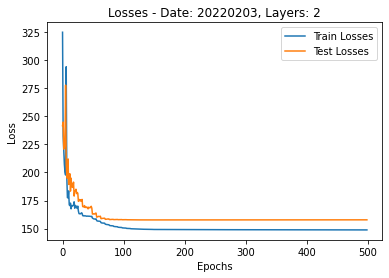

(14400, 44) (14400, 44)
R2 Train: 0.1124046685778619, R2 Test: 0.08290589149094837
Date: 20220210_001
Epoch: 000, LR: 0.010000, Train Loss: 369.0986801, Test Loss: 253.8973100
Epoch: 050, LR: 0.002401, Train Loss: 133.2412326, Test Loss: 124.0339690
Epoch: 100, LR: 0.001176, Train Loss: 130.6094100, Test Loss: 123.4314488
Epoch: 150, LR: 0.000097, Train Loss: 127.9515575, Test Loss: 122.9441537
Epoch: 200, LR: 0.000010, Train Loss: 127.6158553, Test Loss: 122.9870256
Epoch: 250, LR: 0.000010, Train Loss: 127.5919885, Test Loss: 123.0003698
Epoch: 300, LR: 0.000010, Train Loss: 127.5692112, Test Loss: 123.0129320
Epoch: 350, LR: 0.000010, Train Loss: 127.5474580, Test Loss: 123.0308844
Epoch: 400, LR: 0.000010, Train Loss: 127.5265011, Test Loss: 123.0505153
Epoch: 450, LR: 0.000010, Train Loss: 127.5062826, Test Loss: 123.0651811
Time to train model: 74.98574423789978


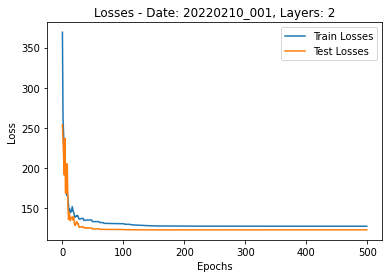

(14400, 62) (14400, 62)
R2 Train: 0.031160042930917328, R2 Test: -0.010106746532830791
Date: 20220210_002
Epoch: 000, LR: 0.010000, Train Loss: 378.4796326, Test Loss: 328.1031125
Epoch: 050, LR: 0.001681, Train Loss: 139.0441901, Test Loss: 144.9504060
Epoch: 100, LR: 0.000198, Train Loss: 134.4025531, Test Loss: 143.9358576
Epoch: 150, LR: 0.000011, Train Loss: 133.7502723, Test Loss: 144.0304594
Epoch: 200, LR: 0.000010, Train Loss: 133.7197904, Test Loss: 144.0439945
Epoch: 250, LR: 0.000010, Train Loss: 133.6946727, Test Loss: 144.0652654
Epoch: 300, LR: 0.000010, Train Loss: 133.6695156, Test Loss: 144.0761691
Epoch: 350, LR: 0.000010, Train Loss: 133.6452322, Test Loss: 144.0757425
Epoch: 400, LR: 0.000010, Train Loss: 133.6221225, Test Loss: 144.0722317
Epoch: 450, LR: 0.000010, Train Loss: 133.5996958, Test Loss: 144.0634352
Time to train model: 71.91990303993225


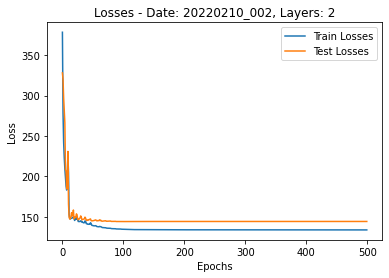

(14400, 62) (14400, 62)
R2 Train: 0.06552669846410882, R2 Test: -0.0026736985651641394
Date: 20220224
Epoch: 000, LR: 0.010000, Train Loss: 300.8786729, Test Loss: 248.4957364
Epoch: 050, LR: 0.001681, Train Loss: 110.9855895, Test Loss: 111.5789269
Epoch: 100, LR: 0.000097, Train Loss: 108.7151258, Test Loss: 110.9436381
Epoch: 150, LR: 0.000010, Train Loss: 108.5365985, Test Loss: 110.9637693
Epoch: 200, LR: 0.000010, Train Loss: 108.5263374, Test Loss: 110.9782266
Epoch: 250, LR: 0.000010, Train Loss: 108.5166573, Test Loss: 110.9913928
Epoch: 300, LR: 0.000010, Train Loss: 108.5073344, Test Loss: 111.0029956
Epoch: 350, LR: 0.000010, Train Loss: 108.4981498, Test Loss: 111.0140404
Epoch: 400, LR: 0.000010, Train Loss: 108.4890323, Test Loss: 111.0258355
Epoch: 450, LR: 0.000010, Train Loss: 108.4799112, Test Loss: 111.0381523
Time to train model: 76.51680707931519


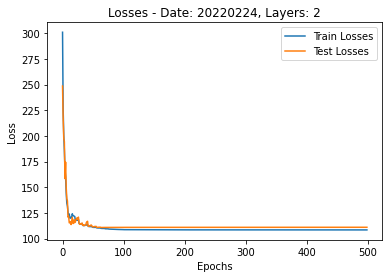

(14400, 108) (14400, 108)
R2 Train: 0.01900529218780658, R2 Test: -0.02147311576617906


In [51]:
all_instance_data = []

r2_train_list = []
r2_test_list = []
pr2_train_list = []
pr2_test_list = []

for j, (train_dataset, test_dataset) in enumerate(zip(train_loader_mlp_list, test_loader_mlp_list)):

    if j > 3:
        model = FCNet(input_dim = 15, output_dim=dataset_list[j-4].num_neural_units, num_layers = 2, hidden_layer_dim = 35).to(device)
        date = dataset_list[j-4].date
    else:
        model = FCNet(input_dim = 69, output_dim=dataset_list[j-4].num_neural_units, num_layers = 2, hidden_layer_dim = 35).to(device)
        date = dataset_list[j].date
    print('Date: {}'.format(date))

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
    total_params = sum(p.numel() for p in model.parameters())

    train_losses = []
    val_losses = []
    test_losses = []
    start = time.time()
    for epoch in range(500):
        lr = scheduler.optimizer.param_groups[0]['lr']
        train_loss = train(train_dataset, model, optimizer, criterion)
        test_loss = test(test_dataset, model, optimizer, criterion)
        scheduler.step(test_loss)
        if epoch % 50==0:
            print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                  .format(epoch, lr, train_loss, test_loss))

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        # print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
        #           .format(epoch, lr, train_loss, test_loss))
    end = time.time()
    print('Time to train model: {}'.format(end-start))
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.title('Losses - Date: {}, Layers: {}'.format(date, model.num_layers))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Losses', 'Test Losses'])
    plt.show()

    train_instance_data = get_instance_losses(train_dataset, model, mlp = True)
    test_instance_data = get_instance_losses(test_dataset, model, mlp = True)
    instance_data = [train_instance_data, test_instance_data]

    print(train_instance_data[2].shape,train_instance_data[3].shape)
    r2_train = sklearn.metrics.r2_score(train_instance_data[2],train_instance_data[3],multioutput='variance_weighted')
    r2_test = sklearn.metrics.r2_score(test_instance_data[2],test_instance_data[3],multioutput='variance_weighted')
    print('R2 Train: {}, R2 Test: {}'.format(r2_train, r2_test))

Date: 20220203
Model Number: 0
Num Conv Layers: 2, Total Parameters: 14024
Epoch: 000, LR: 0.010000, Train Loss: 784.1384888, Test Loss: 608.0330811
Epoch: 050, LR: 0.007000, Train Loss: 20.8316078, Test Loss: 20.0365791
Epoch: 100, LR: 0.007000, Train Loss: 3.8635037, Test Loss: 3.7619088
Epoch: 150, LR: 0.007000, Train Loss: 1.3646047, Test Loss: 1.3425120
Epoch: 200, LR: 0.007000, Train Loss: 0.6883734, Test Loss: 0.6810024
Epoch: 250, LR: 0.007000, Train Loss: 0.4433883, Test Loss: 0.4402410
Epoch: 300, LR: 0.007000, Train Loss: 0.3278531, Test Loss: 0.3261870
Epoch: 350, LR: 0.007000, Train Loss: 0.2615847, Test Loss: 0.2605456
Epoch: 400, LR: 0.007000, Train Loss: 0.2191866, Test Loss: 0.2184856
Epoch: 450, LR: 0.007000, Train Loss: 0.1893242, Test Loss: 0.1888185
Time to train model: 1.1330747604370117


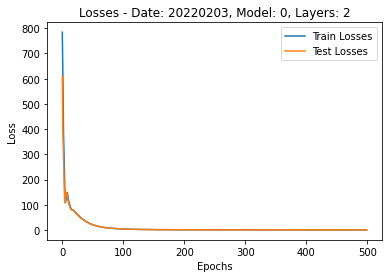

R2 Train: 0.9982736499936349, R2 Test: 0.9982736499936349
Date: 20220210_001
Model Number: 0
Num Conv Layers: 2, Total Parameters: 15122
Epoch: 000, LR: 0.010000, Train Loss: 275.6004333, Test Loss: 149.4460602
Epoch: 050, LR: 0.010000, Train Loss: 7.2883835, Test Loss: 7.0867782
Epoch: 100, LR: 0.010000, Train Loss: 3.2746751, Test Loss: 3.2454927
Epoch: 150, LR: 0.010000, Train Loss: 2.4016273, Test Loss: 2.3900611
Epoch: 200, LR: 0.004900, Train Loss: 1.9957576, Test Loss: 2.0974021
Epoch: 250, LR: 0.004900, Train Loss: 1.8299305, Test Loss: 1.8267837
Epoch: 300, LR: 0.004900, Train Loss: 1.7055404, Test Loss: 1.7033548
Epoch: 350, LR: 0.004900, Train Loss: 1.6098220, Test Loss: 1.6081855
Epoch: 400, LR: 0.004900, Train Loss: 1.5388920, Test Loss: 1.5376511
Epoch: 450, LR: 0.004900, Train Loss: 1.4844533, Test Loss: 1.4835039
Time to train model: 1.0161936283111572


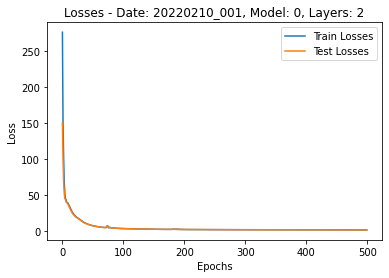

R2 Train: 0.9617854827944634, R2 Test: 0.9617854827944634
Date: 20220210_002
Model Number: 0
Num Conv Layers: 2, Total Parameters: 15122
Epoch: 000, LR: 0.010000, Train Loss: 262.8198853, Test Loss: 204.3015289
Epoch: 050, LR: 0.010000, Train Loss: 7.3485055, Test Loss: 7.1040673
Epoch: 100, LR: 0.010000, Train Loss: 1.8094444, Test Loss: 1.7708795
Epoch: 150, LR: 0.010000, Train Loss: 0.8230476, Test Loss: 0.8136960
Epoch: 200, LR: 0.010000, Train Loss: 0.5097526, Test Loss: 0.5052878
Epoch: 250, LR: 0.010000, Train Loss: 0.3523951, Test Loss: 0.3496509
Epoch: 300, LR: 0.010000, Train Loss: 0.2608740, Test Loss: 0.2591426
Epoch: 350, LR: 0.007000, Train Loss: 0.2172189, Test Loss: 0.2103502
Epoch: 400, LR: 0.007000, Train Loss: 0.1829541, Test Loss: 0.1824860
Epoch: 450, LR: 0.007000, Train Loss: 0.1629627, Test Loss: 0.1626168
Time to train model: 0.9773328304290771


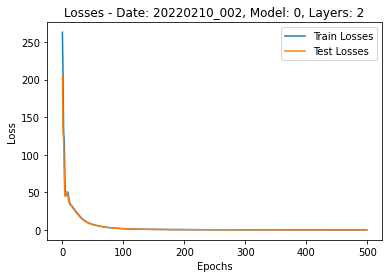

R2 Train: 0.9956512170935932, R2 Test: 0.9956512170935932
Date: 20220224
Model Number: 0
Num Conv Layers: 2, Total Parameters: 17928
Epoch: 000, LR: 0.010000, Train Loss: 352.3126831, Test Loss: 193.3093414
Epoch: 050, LR: 0.010000, Train Loss: 12.4817162, Test Loss: 12.5621815
Epoch: 100, LR: 0.010000, Train Loss: 4.9218278, Test Loss: 4.8651519
Epoch: 150, LR: 0.007000, Train Loss: 3.3819849, Test Loss: 3.3574975
Epoch: 200, LR: 0.007000, Train Loss: 2.7678480, Test Loss: 2.7590449
Epoch: 250, LR: 0.007000, Train Loss: 2.3969564, Test Loss: 2.3914402
Epoch: 300, LR: 0.007000, Train Loss: 2.1611984, Test Loss: 2.1567967
Epoch: 350, LR: 0.004900, Train Loss: 2.0064979, Test Loss: 2.0021842
Epoch: 400, LR: 0.004900, Train Loss: 1.8977107, Test Loss: 1.8958057
Epoch: 450, LR: 0.004900, Train Loss: 1.8153555, Test Loss: 1.8137484
Time to train model: 1.07212495803833


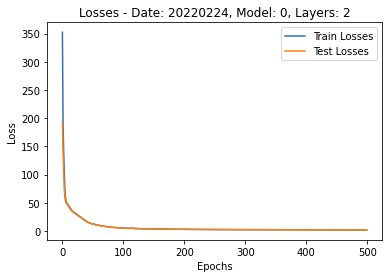

R2 Train: 0.9563561257949076, R2 Test: 0.9563561257949076


In [ ]:
all_instance_data = []

r2_train_list = []
r2_test_list = []
pr2_train_list = []
pr2_test_list = []

for j, (train_dataset, test_dataset) in enumerate(zip(toy_joint_velocities_dataset_list, toy_joint_velocities_dataset_list)):

    output_shape = dataset_list[j].num_neural_units
    print('Date: {}'.format(dataset_list[j].date))
    models_list = [TempConvNet(input_dim = 15, output_dim=output_shape, num_conv_layers = 2, num_readout_layers=1, kernel_size = 5, padding = 2).to(device),\
                  # TempConvNet(input_dim = 92, output_dim=output_shape, num_conv_layers = 3, kernel_size = 5, padding = 2).to(device),\
                  # TempConvNet(input_dim = 92, output_dim=output_shape, num_conv_layers = 4, kernel_size = 5, padding = 2).to(device)
                  ]

    model_instance_data = []
    for i, model in enumerate(models_list):
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
        total_params = sum(p.numel() for p in model.parameters())

        print('Model Number: {}'.format(i))
        print('Num Conv Layers: {}, Total Parameters: {}'\
            .format(model.num_conv_layers, total_params))

        train_losses = []
        val_losses = []
        test_losses = []
        start = time.time()
        for epoch in range(500):
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train(train_dataset, model, optimizer, criterion)
            test_loss = test(test_dataset, model, optimizer, criterion)
            scheduler.step(test_loss)
            if epoch % 50==0:
                print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                      .format(epoch, lr, train_loss, test_loss))

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            # print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
            #           .format(epoch, lr, train_loss, test_loss))
        end = time.time()
        print('Time to train model: {}'.format(end-start))
        plt.plot(train_losses)
        plt.plot(test_losses)
        plt.title('Losses - Date: {}, Model: {}, Layers: {}'.format(dataset_list[j].date, i, model.num_conv_layers))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train Losses', 'Test Losses'])
        plt.show()

        train_instance_data = get_instance_losses(train_dataset, model)
        test_instance_data = get_instance_losses(test_dataset, model)
        instance_data = [train_instance_data, test_instance_data]

        r2_train = sklearn.metrics.r2_score(train_instance_data[2],train_instance_data[3],multioutput='variance_weighted')
        r2_test = sklearn.metrics.r2_score(test_instance_data[2],test_instance_data[3],multioutput='variance_weighted')
        # pr2_train = get_pr2(train_instance_data[2],train_instance_data[3])
        # pr2_test = get_pr2(test_instance_data[2],test_instance_data[3])
        print('R2 Train: {}, R2 Test: {}'.format(r2_train, r2_test))

        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)
        # pr2_train_list.append(pr2_train)
        # pr2_test_list.append(pr2_test)

        # save model
        directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/PopJarvisExperiments/'
        model_name = 'date{}_layers{}.pth'.format(dataset_list[j].date, model.num_conv_layers)
        # torch.save(model.state_dict(), directory+model_name)

Date: 20220203
Model Number: 0
Num Conv Layers: 2, Total Parameters: 14024
Epoch: 000, LR: 0.010000, Train Loss: 183.3762752, Test Loss: 606.5612861
Epoch: 050, LR: 0.007000, Train Loss: 118.4993237, Test Loss: 420.1769057
Epoch: 100, LR: 0.007000, Train Loss: 119.3467991, Test Loss: 413.8824179
Epoch: 150, LR: 0.004900, Train Loss: 119.2660441, Test Loss: 413.1442413
Epoch: 200, LR: 0.002401, Train Loss: 119.1712057, Test Loss: 412.6034614
Epoch: 250, LR: 0.000282, Train Loss: 119.0907386, Test Loss: 412.3271582
Epoch: 300, LR: 0.000016, Train Loss: 119.0805753, Test Loss: 412.2890239
Epoch: 350, LR: 0.000010, Train Loss: 119.0803236, Test Loss: 412.2837185
Epoch: 400, LR: 0.000010, Train Loss: 119.0803116, Test Loss: 412.2784097
Epoch: 450, LR: 0.000010, Train Loss: 119.0803001, Test Loss: 412.2731595
Time to train model: 117.04209566116333


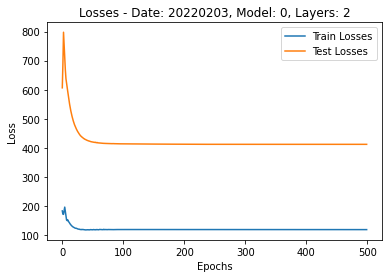

R2 Train: -5.558656434976242e-06, R2 Test: -1.2081209581756054
Model Number: 1
Num Conv Layers: 2, Total Parameters: 16004
Epoch: 000, LR: 0.010000, Train Loss: 169.1478288, Test Loss: 523.9564633
Epoch: 050, LR: 0.010000, Train Loss: 123.4644736, Test Loss: 455.9380646
Epoch: 100, LR: 0.010000, Train Loss: 122.8437964, Test Loss: 449.2007510
Epoch: 150, LR: 0.010000, Train Loss: 122.3574224, Test Loss: 443.7754309
Epoch: 200, LR: 0.010000, Train Loss: 122.1834490, Test Loss: 442.1084294
Epoch: 250, LR: 0.010000, Train Loss: 121.9603893, Test Loss: 439.8575681
Epoch: 300, LR: 0.010000, Train Loss: 121.4812687, Test Loss: 434.3410797
Epoch: 350, LR: 0.004900, Train Loss: 120.0996487, Test Loss: 420.7288386
Epoch: 400, LR: 0.001681, Train Loss: 119.4354555, Test Loss: 415.3402023
Epoch: 450, LR: 0.001176, Train Loss: 119.3261892, Test Loss: 413.9104084
Time to train model: 143.76617193222046


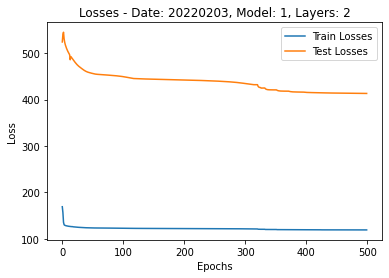

R2 Train: -2.199140019053506e-05, R2 Test: -1.2124510384288816
Model Number: 2
Num Conv Layers: 3, Total Parameters: 52784
Epoch: 000, LR: 0.010000, Train Loss: 226.3649029, Test Loss: 539.6110463
Epoch: 050, LR: 0.010000, Train Loss: 124.2917929, Test Loss: 467.6168908


KeyboardInterrupt: ignored

In [ ]:
all_instance_data = []

r2_train_list = []
r2_test_list = []
pr2_train_list = []
pr2_test_list = []

for j, (train_dataset, test_dataset) in enumerate(zip(train_joint_velocities_dataset_list, test_joint_velocities_dataset_list)):

    output_shape = dataset_list[j].num_neural_units
    print('Date: {}'.format(dataset_list[j].date))
    models_list = [TempConvNet(input_dim = 15, output_dim=output_shape, num_conv_layers = 2, num_readout_layers = 1, kernel_size = 5, padding = 2).to(device),\
                  TempConvNet(input_dim = 15, output_dim=output_shape, num_conv_layers = 2, num_readout_layers = 2, kernel_size = 5, padding = 2).to(device),\
                  TempConvNet(input_dim = 15, output_dim=output_shape, num_conv_layers = 3, num_readout_layers = 1, kernel_size = 5, padding = 2).to(device),\
                  TempConvNet(input_dim = 15, output_dim=output_shape, num_conv_layers = 3, num_readout_layers = 2, kernel_size = 5, padding = 2).to(device)
                  ]

    model_instance_data = []
    for i, model in enumerate(models_list):
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
        total_params = sum(p.numel() for p in model.parameters())

        print('Model Number: {}'.format(i))
        print('Num Conv Layers: {}, Total Parameters: {}'\
            .format(model.num_conv_layers, total_params))

        train_losses = []
        val_losses = []
        test_losses = []
        start = time.time()
        for epoch in range(500):
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train(train_dataset, model, optimizer, criterion)
            test_loss = test(test_dataset, model, optimizer, criterion)
            scheduler.step(test_loss)
            if epoch % 50==0:
                print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                      .format(epoch, lr, train_loss, test_loss))

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            # print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
            #           .format(epoch, lr, train_loss, test_loss))
        end = time.time()
        print('Time to train model: {}'.format(end-start))
        plt.plot(train_losses)
        plt.plot(test_losses)
        plt.title('Losses - Date: {}, Model: {}, Layers: {}'.format(dataset_list[j].date, i, model.num_conv_layers))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train Losses', 'Test Losses'])
        plt.show()

        train_instance_data = get_instance_losses(train_dataset, model)
        test_instance_data = get_instance_losses(test_dataset, model)
        instance_data = [train_instance_data, test_instance_data]

        r2_train = sklearn.metrics.r2_score(train_instance_data[2],train_instance_data[3],multioutput='variance_weighted')
        r2_test = sklearn.metrics.r2_score(test_instance_data[2],test_instance_data[3],multioutput='variance_weighted')
        # pr2_train = get_pr2(train_instance_data[2],train_instance_data[3])
        # pr2_test = get_pr2(test_instance_data[2],test_instance_data[3])
        print('R2 Train: {}, R2 Test: {}'.format(r2_train, r2_test))

        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)
        # pr2_train_list.append(pr2_train)
        # pr2_test_list.append(pr2_test)

        # save model
        directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/PopJarvisExperiments/'
        model_name = 'date{}_layers{}.pth'.format(dataset_list[j].date, model.num_conv_layers)
        # torch.save(model.state_dict(), directory+model_name)

# GLM Baseline

In [ ]:
# [dataset][tuple][input/output]
glm_train_inputs = []
glm_train_targets = []
for i in range(len(train_joint_velocities_dataset_list)):
    dataset = train_joint_velocities_dataset_list[i]
    inputs = []
    targets = []
    for j in range(len(dataset)):
        tup = dataset[j]
        inp = tup[0]
        target = tup[1]
        inputs.append(inp)
        targets.append(target)
    dataset_inputs = np.hstack(inputs).T
    dataset_targets = np.vstack(targets)
    glm_train_inputs.append(dataset_inputs)
    glm_train_targets.append(dataset_targets)

In [ ]:
glm_test_inputs = []
glm_test_targets = []
for i in range(len(test_joint_velocities_dataset_list)):
    dataset = test_joint_velocities_dataset_list[i]
    inputs = []
    targets = []
    for j in range(len(dataset)):
        tup = dataset[j]
        inp = tup[0]
        target = tup[1]
        inputs.append(inp)
        targets.append(target)
    dataset_inputs = np.hstack(inputs).T
    dataset_targets = np.vstack(targets)
    glm_test_inputs.append(dataset_inputs)
    glm_test_targets.append(dataset_targets)

In [ ]:
len(glm_train_inputs), len(glm_train_targets), len(glm_test_inputs), len(glm_test_targets)

(4, 4, 4, 4)

In [ ]:
glm_train_inputs[0].shape, glm_train_targets[0].shape, glm_test_inputs[0].shape, glm_test_targets[0].shape

((14400, 15), (14400, 44), (3600, 15), (3600, 44))

In [ ]:
/content/drive/MyDrive/Miller_Lab/FIU/PopFR_Jarvis/

/content


In [ ]:
from google.colab import files

In [ ]:
io.savemat('/content/20220203_data.mat',dict(train_x=glm_train_inputs[0], train_y=glm_train_targets[0], test_x=glm_test_inputs[0], test_y=glm_test_targets[0]))
io.savemat('/content/20220210_001_data.mat',dict(train_x=glm_train_inputs[1], train_y=glm_train_targets[1], test_x=glm_test_inputs[1], test_y=glm_test_targets[1]))
io.savemat('/content/20220210_002_data.mat',dict(train_x=glm_train_inputs[2], train_y=glm_train_targets[2], test_x=glm_test_inputs[2], test_y=glm_test_targets[2]))
io.savemat('/content/20220224_data.mat',dict(train_x=glm_train_inputs[3], train_y=glm_train_targets[3], test_x=glm_test_inputs[3], test_y=glm_test_targets[3]))

In [ ]:
print('Poisson GLM Results')
for n in range(len(glm_train_inputs)):
    train_targ_n = glm_train_targets[n]
    train_inp_n = glm_train_inputs[n]

    test_targ_n = glm_test_targets[n]
    test_inp_n = glm_test_inputs[n]

    train_pr2_list = []
    test_pr2_list = []

    for i in range(train_targ_n.shape[1]):
        glm_poisson = sm.GLM(train_targ_n[:,i], train_inp_n, family=sm.families.Poisson())
        res = glm_poisson.fit()
        train_pred = glm_poisson.predict(res.params, exog=train_inp_n)
        test_pred = glm_poisson.predict(res.params, exog=test_inp_n)
        train_pr2_list.append(get_pr2(train_targ_n[:,i], train_pred))
        test_pr2_list.append(get_pr2(test_targ_n[:,i], test_pred))
    train_avg_pr2 = sum(train_pr2_list)/len(train_pr2_list)
    test_avg_pr2 = sum(test_pr2_list)/len(test_pr2_list)
    print('Average Train pR2 for {} dataset: {}'.format(dataset_list[n].date, train_avg_pr2))
    print('Average Test pR2 for {} dataset: {}'.format(dataset_list[n].date, test_avg_pr2))
    print('\n')

Poisson GLM Results
Average Train pR2 for 20220203 dataset: -3.7812580204541346
Average Test pR2 for 20220203 dataset: -17.35655134055261


Average Train pR2 for 20220210_001 dataset: -7.970920949817034
Average Test pR2 for 20220210_001 dataset: -7.441614735689414


Average Train pR2 for 20220210_002 dataset: -6.218056646483844
Average Test pR2 for 20220210_002 dataset: -6.940678958363681


Average Train pR2 for 20220224 dataset: -5.672331335454482
Average Test pR2 for 20220224 dataset: -5.516034881302636


